# Table of contents
1. [Tune U-net model on real data](#save_best_unet)
2. [Evaluate best model on test images](#evaluate_best_unet)
3. [Train U-net on data augmented with simple augmentations](#train_augmentation_simple)
4. [Evaluate augmented model on test images](#test_augment_simple)
5. [Train U-net on data augmented with Pix2Pix (no jittering)](#augment_pix2pix_no_jittering)
6. [Evaluate augmented model on test images](#evaluate_augment_pix2pix_no_jittering)

In [2]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Dropout, Reshape, Conv2DTranspose, Activation, BatchNormalization, LeakyReLU, AveragePooling2D, Flatten, Dense, ReLU, Lambda
import tensorflow as tf
from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np
from math import ceil
import tensorflow.keras.backend as K

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
def mean_iou(y_true, y_pred):
    yt0 = K.cast(y_true[:,:,:,0] > 0.5, 'float32')
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [4]:
def false_positives(y_true, y_pred):
    yt0 = K.cast(y_true[:,:,:,0] > 0.5, 'float32')
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    return (tf.math.count_nonzero(yp0) - inter) / BATCH_SIZE

In [5]:
def false_negatives(y_true, y_pred):
    yt0 = K.cast(y_true[:,:,:,0] > 0.5, 'float32')
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    return (tf.math.count_nonzero(yt0) - inter) / BATCH_SIZE

In [6]:
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 1

In [7]:
# Normalize [-1, 1] input images
def normalize(img):
    img = (img - 127.5) / 127.5
    return img

# Make mask a binary mask
def binarize(mask):
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    return mask

In [8]:
KERNEL_INITIALIZER = tf.random_normal_initializer(mean=0., stddev=0.02, seed=1)

In [9]:
def get_encoder_layer(filters, kernel_size, use_batchnorm=True):
    encoder_layer = Sequential([
        Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=2,
            padding='same',
            kernel_initializer=KERNEL_INITIALIZER,
            use_bias=False
        )
    ])

    if use_batchnorm:
        encoder_layer.add(BatchNormalization())

    encoder_layer.add(LeakyReLU(0.2))
    return encoder_layer

In [10]:
def get_decoder_layer(filters, kernel_size, dropout_rate, use_dropout=False):
    decoder_layer = Sequential()
    decoder_layer.add(
        Conv2DTranspose(
            filters=filters,
            kernel_size=kernel_size,
            strides=2,
            padding='same',
            kernel_initializer=KERNEL_INITIALIZER,
            use_bias=False
        )
    )
    decoder_layer.add(BatchNormalization())

    if use_dropout:
        decoder_layer.add(Dropout(dropout_rate))

    decoder_layer.add(ReLU())
    return decoder_layer

In [11]:
def get_generator(dropout_rate):
    inputs = tf.keras.Input(shape=[128, 128, INPUT_CHANNELS])
    outputs = inputs

    downsampling_args = [
        # from (256, 256, 1) to (128, 128, 64)
        {'filters': 64, 'use_batchnorm': False},
        # from (128, 128, 64) to (64, 64, 128)
        {'filters': 128, 'use_batchnorm': False},
        # from (64, 64, 128) to (32, 32, 256)
        {'filters': 256, 'use_batchnorm': True},
        # from (32, 32, 256) to (16, 16, 512)
        {'filters': 512, 'use_batchnorm': True},
        # from (32, 32, 256) to (16, 16, 512)
        {'filters': 512, 'use_batchnorm': True},
        # from (16, 16, 512) to (8, 8, 512)
        {'filters': 512, 'use_batchnorm': True},
        # from (8, 8, 512) to (4, 4, 512)
        {'filters': 512, 'use_batchnorm': True},
    ]

    upsampling_args = [
        {'filters': 512, 'use_dropout': True},
        {'filters': 512, 'use_dropout': True},
        {'filters': 512, 'use_dropout': False},
        {'filters': 256, 'use_dropout': False},
        {'filters': 128, 'use_dropout': False},
        {'filters': 64, 'use_dropout': False}
    ]

    # Add downsampling layers
    skips = []
    for d in downsampling_args:
        outputs = get_encoder_layer(kernel_size=4,**d)(outputs)
        skips.append(outputs)

    # Add upsampling layers and skip connections
    for up, skip in zip(upsampling_args, skips[-2::-1]):
        outputs = get_decoder_layer(kernel_size=4, dropout_rate=dropout_rate, **up)(outputs)
        outputs = Concatenate()([outputs, skip])

    # From (128, 128, ) to (256, 256, 3)
    outputs = Conv2DTranspose(
        filters=OUTPUT_CHANNELS,
        kernel_size=4,
        strides=2,
        padding='same',
        kernel_initializer=KERNEL_INITIALIZER,
        activation='tanh'
    )(outputs)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

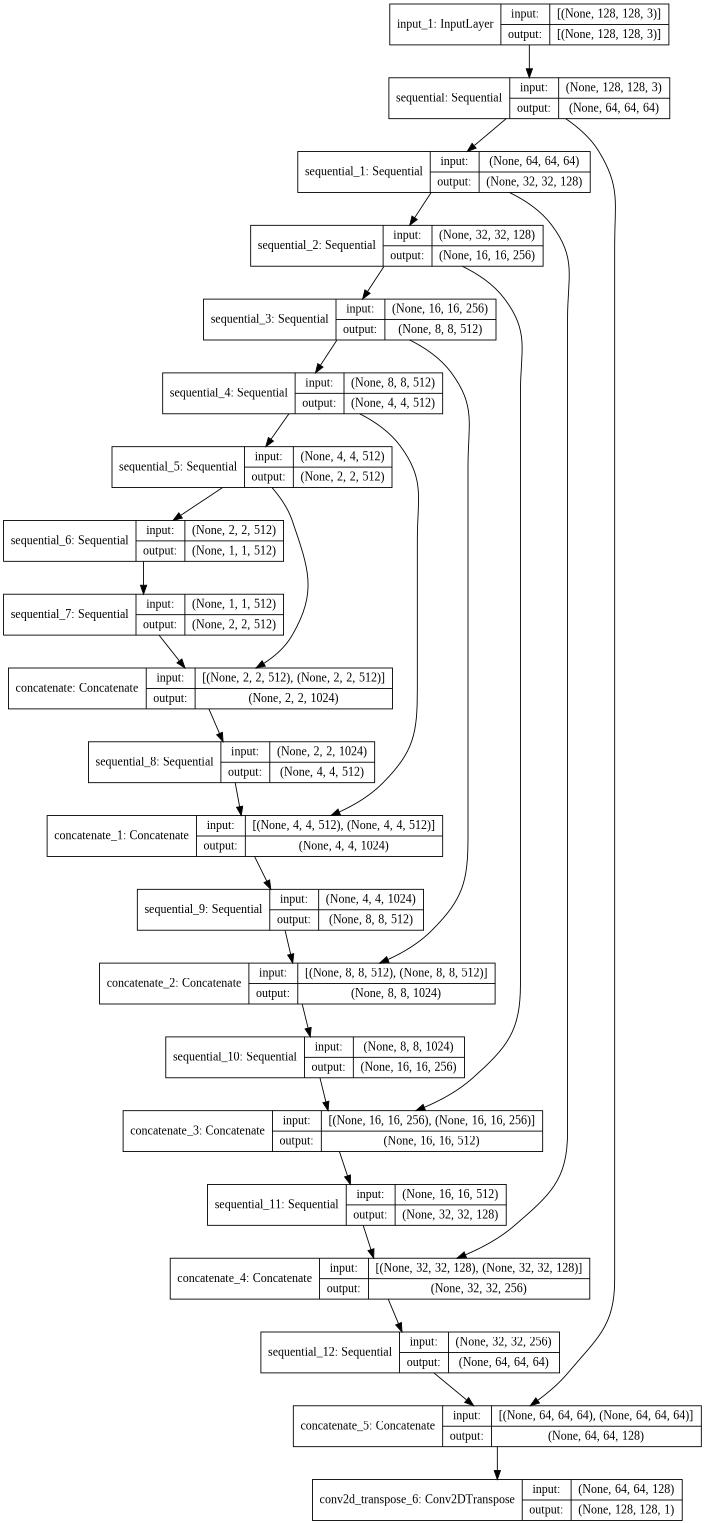

In [12]:
check_model = get_generator(0.5)
tf.keras.utils.plot_model(check_model, show_shapes=True, dpi=64)

In [13]:
def get_model(optimizer, learning_rate, dropout_rate):
    model = get_generator(dropout_rate)

    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss=['binary_crossentropy'],
                  metrics=[
                      mean_iou,
        false_positives,
        false_negatives
    ]
    )
    model.summary()

    return model

### Data generator is used in order not to store all images and segmentation masks in memory at once

In [14]:
image_generator = ImageDataGenerator(
    preprocessing_function=normalize,
    validation_split=0.2
)
mask_generator = ImageDataGenerator(
    preprocessing_function=binarize,
    validation_split=0.2
)

In [15]:
BATCH_SIZE = 16

flow_args = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'target_size': (128, 128),
    'class_mode': None,
    'seed': 1    
}

TRAIN_DIR = '../../dataset'

train_generator = zip(
    image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['image'],
        color_mode='rgb',
        subset='training',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['mask'],
        color_mode='grayscale',
        subset='training',
        **flow_args
    )
)

validation_generator = zip(
    image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['image'],
        color_mode='rgb',
        subset='validation',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['mask'],
        color_mode='grayscale',
        subset='validation',
        **flow_args
    )
)

dataset_args = {
    'output_types': (tf.float32,) * 2,
    'output_shapes': ([None, 128, 128, 3], [None, 128, 128, 1])
}

train_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, train_generator),
    **dataset_args
)

validation_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, validation_generator),
    **dataset_args
)

Found 2076 images belonging to 1 classes.
Found 2076 images belonging to 1 classes.
Found 518 images belonging to 1 classes.
Found 518 images belonging to 1 classes.


In [16]:
def denormalize(img):
    img = img*127.5+127.5
    return img.astype(np.uint8)

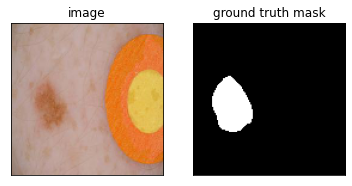

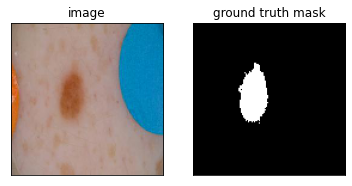

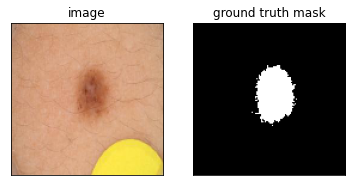

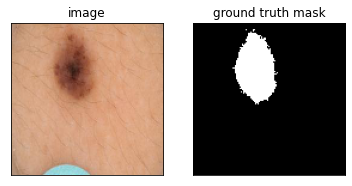

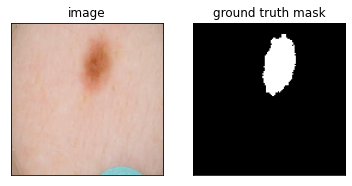

In [17]:
# Check images and masks are loaded properly
images, masks = next(train_generator)

for i, m in list(zip(images, masks))[:5]:
    _, axarr = plt.subplots(1, 2)

    plot_args = {
        'title': ['image', 'ground truth mask'],
        'args': [
            {'X': denormalize(i)},
            {'X': m[:, :, 0], 'cmap': 'gray'},
        ]
    }

    for ax, t, a in zip(axarr, plot_args['title'], plot_args['args']):
        ax.set_title(t)
        fig = ax.imshow(**a)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [18]:
class ImageCallback(keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        mask = self.model.predict(images)[0]
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1

        plot_args = {
            'title': ['image', 'predicted mask', 'ground truth mask'],
            'args': [
                {'X': denormalize(images[0])},
                {'X': mask[:, :, 0], 'cmap': 'gray'},
                {'X': masks[0, :, :, 0], 'cmap': 'gray'}
            ]
        }
        _, axarr = plt.subplots(1, 3)

        for ax, t, a in zip(axarr, plot_args['title'], plot_args['args']):
            ax.set_title(t)
            fig = ax.imshow(**a)
            ax.axis('off')
        plt.show()

In [19]:
TRAIN_COUNT = 2076
VALIDATION_COUNT = 518
TUNE_EPOCHS = 100

In [20]:
def get_callbacks(idx):
    CHECKPOINT_PATH = f'checkpoints/{idx}'
    
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{CHECKPOINT_PATH}',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_mean_iou',
        mode='max',
        verbose=1
    )

    image_callback = ImageCallback(model)

    LOG_DIR = f'logs/{idx}'
    board_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

    return best_checkpoint, board_callback, image_callback

## Train U-net on data augmented with Pix2Pix2 (no jittering)<a name='augment_pix2pix_no_jittering'></a>

3594 training (2594 real and 1000 synthetic) are used during training

In [21]:
from itertools import chain

In [22]:
BATCH_SIZE = 16

flow_args = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'target_size': (128, 128),
    'class_mode': None,
    'seed': 1
}

TRAIN_DIR = '../../dataset'

train_generator = zip(
    image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['image'],
        color_mode='rgb',
        subset='training',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['mask'],
        color_mode='grayscale',
        subset='training',
        **flow_args
    )
)

train_generator = chain(train_generator,
                        zip(
                            image_generator.flow_from_directory(
                                directory=TRAIN_DIR,
                                classes=['image_aug2'],
                                color_mode='rgb',
                                **flow_args
                            ),
                            mask_generator.flow_from_directory(
                                directory=TRAIN_DIR,
                                classes=['mask_aug2'],
                                color_mode='grayscale',
                                **flow_args
                            )
                        )
                        )

validation_generator = zip(
    image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['image'],
        color_mode='rgb',
        subset='validation',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['mask'],
        color_mode='grayscale',
        subset='validation',
        **flow_args
    )
)

dataset_args = {
    'output_types': (tf.float32,) * 2,
    'output_shapes': ([None, 128, 128, 3], [None, 128, 128, 1])
}

train_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, train_generator),
    **dataset_args
)

validation_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, validation_generator),
    **dataset_args
)

Found 2076 images belonging to 1 classes.
Found 2076 images belonging to 1 classes.
Found 2594 images belonging to 1 classes.
Found 2594 images belonging to 1 classes.
Found 518 images belonging to 1 classes.
Found 518 images belonging to 1 classes.


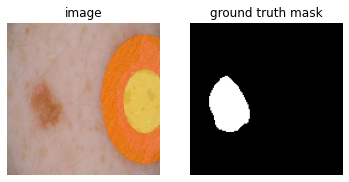

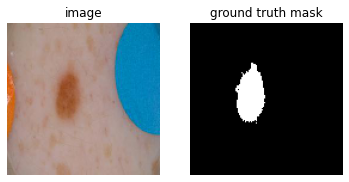

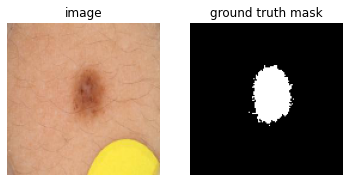

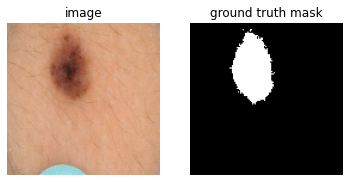

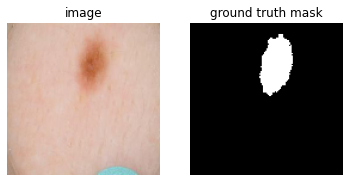

In [23]:
# Check images and masks are loaded properly
images, masks = next(train_generator)

for i, m in list(zip(images, masks))[:5]:
    _, axarr = plt.subplots(1, 2)

    plot_args = {
        'title': ['image', 'ground truth mask'],
        'args': [
            {'X': denormalize(i)},
            {'X': m[:, :, 0], 'cmap': 'gray'},
        ]
    }

    for ax, t, a in zip(axarr, plot_args['title'], plot_args['args']):
        ax.set_title(t)
        fig = ax.imshow(**a)
        ax.axis('off')
    plt.show()

In [24]:
TRAIN_COUNT = 3076
VALIDATION_COUNT = 518
EPOCHS = 100

In [25]:
model = get_model(
    optimizer=tf.keras.optimizers.Adam,
    learning_rate=1e-3,
    dropout_rate=0.4
)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 64, 64, 64)   3072        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 32, 32, 128)  131072      sequential_13[0][0]              
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 16, 16, 256)  525312      sequential_14[0][0]              
____________________________________________________________________________________________

In [26]:
CHECKPOINT_PATH = f'checkpoints/train_aug2/100'
    
best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{CHECKPOINT_PATH}',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_mean_iou',
    mode='max',
    verbose=1
)

image_callback = ImageCallback(model)

LOG_DIR = f'logs/train_aug2'
board_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

In [27]:
model.load_weights(f'checkpoints/train_aug2/100')

Epoch 23/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpkfusy8q3.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpkfusy8q3.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpy8qual67.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity

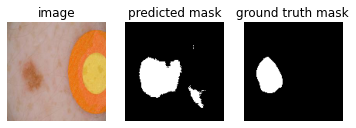

Epoch 24/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0708 - mean_iou: 0.8232 - false_positives: 201.6795 - false_negatives: 263.0954 - val_loss: 0.1726 - val_mean_iou: 0.8029 - val_false_positives: 369.0625 - val_false_negatives: 511.6250

Epoch 00024: val_mean_iou improved from 0.75606 to 0.80286, saving model to checkpoints/train_aug2/100


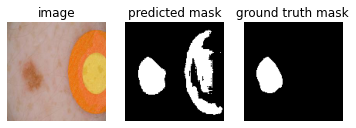

Epoch 25/100
193/193 [==============================] - 59s 307ms/step - loss: 0.0581 - mean_iou: 0.8562 - false_positives: 178.5731 - false_negatives: 209.4635 - val_loss: 0.2531 - val_mean_iou: 0.7679 - val_false_positives: 165.2045 - val_false_negatives: 870.2064

Epoch 00025: val_mean_iou did not improve from 0.80286


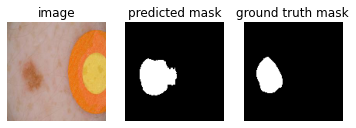

Epoch 26/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0708 - mean_iou: 0.8335 - false_positives: 198.4251 - false_negatives: 248.1576 - val_loss: 0.1676 - val_mean_iou: 0.8060 - val_false_positives: 347.1345 - val_false_negatives: 525.2462

Epoch 00026: val_mean_iou improved from 0.80286 to 0.80599, saving model to checkpoints/train_aug2/100


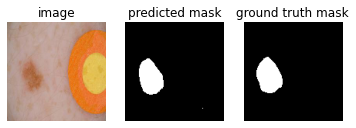

Epoch 27/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0623 - mean_iou: 0.8374 - false_positives: 187.6639 - false_negatives: 229.7548 - val_loss: 0.2106 - val_mean_iou: 0.7777 - val_false_positives: 260.6515 - val_false_negatives: 742.6780

Epoch 00027: val_mean_iou did not improve from 0.80599


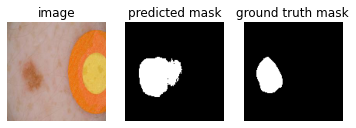

Epoch 28/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0562 - mean_iou: 0.8430 - false_positives: 168.2578 - false_negatives: 204.0998 - val_loss: 0.2230 - val_mean_iou: 0.7985 - val_false_positives: 310.6534 - val_false_negatives: 571.2197

Epoch 00028: val_mean_iou did not improve from 0.80599


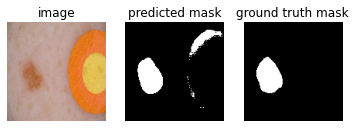

Epoch 29/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0591 - mean_iou: 0.8574 - false_positives: 179.8660 - false_negatives: 204.8971 - val_loss: 0.3200 - val_mean_iou: 0.7588 - val_false_positives: 152.0549 - val_false_negatives: 936.1099

Epoch 00029: val_mean_iou did not improve from 0.80599


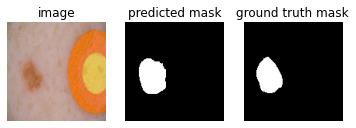

Epoch 30/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0467 - mean_iou: 0.8673 - false_positives: 138.8309 - false_negatives: 166.3344 - val_loss: 0.2825 - val_mean_iou: 0.7980 - val_false_positives: 202.8144 - val_false_negatives: 708.7216

Epoch 00030: val_mean_iou did not improve from 0.80599


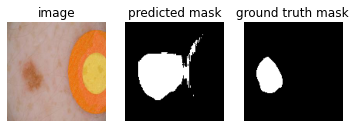

Epoch 31/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0502 - mean_iou: 0.8851 - false_positives: 146.1864 - false_negatives: 195.5078 - val_loss: 0.2392 - val_mean_iou: 0.7973 - val_false_positives: 264.6060 - val_false_negatives: 638.0644

Epoch 00031: val_mean_iou did not improve from 0.80599


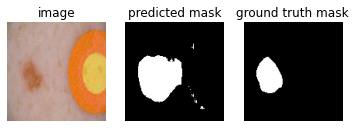

Epoch 32/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0468 - mean_iou: 0.8633 - false_positives: 147.1421 - false_negatives: 161.4350 - val_loss: 0.2807 - val_mean_iou: 0.7875 - val_false_positives: 274.9470 - val_false_negatives: 657.8106

Epoch 00032: val_mean_iou did not improve from 0.80599


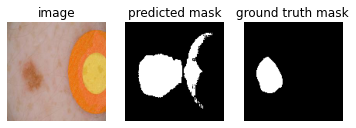

Epoch 33/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0557 - mean_iou: 0.8805 - false_positives: 144.5406 - false_negatives: 227.9294 - val_loss: 0.2301 - val_mean_iou: 0.7891 - val_false_positives: 308.3371 - val_false_negatives: 629.7273

Epoch 00033: val_mean_iou did not improve from 0.80599


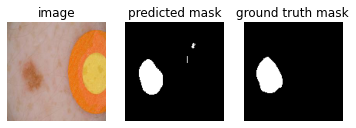

Epoch 34/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0497 - mean_iou: 0.8588 - false_positives: 156.6635 - false_negatives: 154.9557 - val_loss: 0.4217 - val_mean_iou: 0.7258 - val_false_positives: 792.8769 - val_false_negatives: 609.6591

Epoch 00034: val_mean_iou did not improve from 0.80599


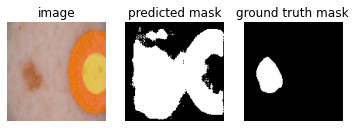

Epoch 35/100
193/193 [==============================] - 60s 310ms/step - loss: 0.1051 - mean_iou: 0.8196 - false_positives: 307.4465 - false_negatives: 304.2763 - val_loss: 0.1853 - val_mean_iou: 0.8013 - val_false_positives: 351.2424 - val_false_negatives: 525.5189

Epoch 00035: val_mean_iou did not improve from 0.80599


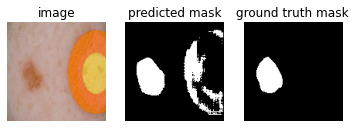

Epoch 36/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0518 - mean_iou: 0.8561 - false_positives: 165.9458 - false_negatives: 165.7484 - val_loss: 0.2368 - val_mean_iou: 0.8050 - val_false_positives: 326.2046 - val_false_negatives: 548.6875

Epoch 00036: val_mean_iou did not improve from 0.80599


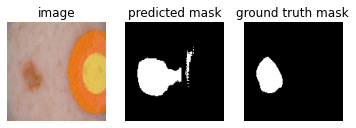

Epoch 37/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0542 - mean_iou: 0.8947 - false_positives: 167.8467 - false_negatives: 184.5339 - val_loss: 0.2333 - val_mean_iou: 0.7980 - val_false_positives: 239.2197 - val_false_negatives: 669.5644

Epoch 00037: val_mean_iou did not improve from 0.80599


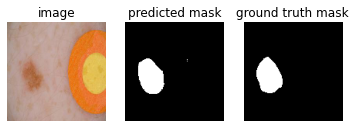

Epoch 38/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0396 - mean_iou: 0.8923 - false_positives: 126.5821 - false_negatives: 131.5512 - val_loss: 0.3303 - val_mean_iou: 0.7913 - val_false_positives: 264.4773 - val_false_negatives: 663.4905

Epoch 00038: val_mean_iou did not improve from 0.80599


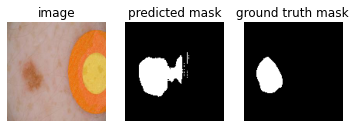

Epoch 39/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0482 - mean_iou: 0.9076 - false_positives: 143.8891 - false_negatives: 169.4319 - val_loss: 0.2172 - val_mean_iou: 0.7979 - val_false_positives: 305.1250 - val_false_negatives: 591.9299

Epoch 00039: val_mean_iou did not improve from 0.80599


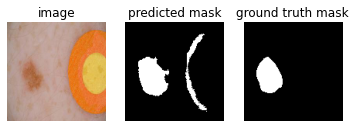

Epoch 40/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0444 - mean_iou: 0.8918 - false_positives: 150.1515 - false_negatives: 136.5807 - val_loss: 0.3053 - val_mean_iou: 0.8005 - val_false_positives: 222.2727 - val_false_negatives: 665.6515

Epoch 00040: val_mean_iou did not improve from 0.80599


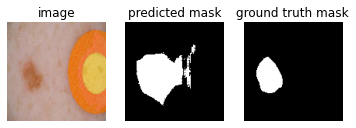

Epoch 41/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0683 - mean_iou: 0.8800 - false_positives: 219.2709 - false_negatives: 208.8893 - val_loss: 0.2762 - val_mean_iou: 0.7916 - val_false_positives: 348.7178 - val_false_negatives: 569.7898

Epoch 00041: val_mean_iou did not improve from 0.80599


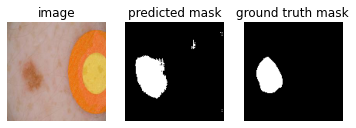

Epoch 42/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0586 - mean_iou: 0.8658 - false_positives: 161.9317 - false_negatives: 211.7888 - val_loss: 0.2088 - val_mean_iou: 0.8078 - val_false_positives: 334.6326 - val_false_negatives: 526.1610

Epoch 00042: val_mean_iou improved from 0.80599 to 0.80781, saving model to checkpoints/train_aug2/100


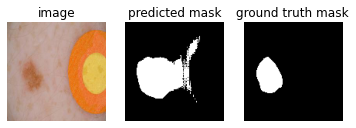

Epoch 43/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0486 - mean_iou: 0.9049 - false_positives: 144.1743 - false_negatives: 167.6547 - val_loss: 0.2321 - val_mean_iou: 0.8084 - val_false_positives: 354.8106 - val_false_negatives: 515.9337

Epoch 00043: val_mean_iou improved from 0.80781 to 0.80843, saving model to checkpoints/train_aug2/100


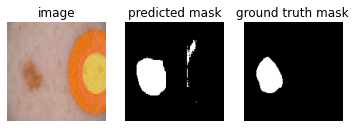

Epoch 44/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0394 - mean_iou: 0.9060 - false_positives: 139.8622 - false_negatives: 123.6537 - val_loss: 0.3387 - val_mean_iou: 0.7963 - val_false_positives: 180.6780 - val_false_negatives: 741.3257

Epoch 00044: val_mean_iou did not improve from 0.80843


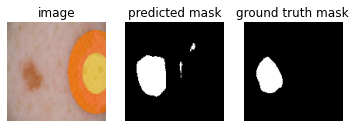

Epoch 45/100
193/193 [==============================] - 60s 312ms/step - loss: 0.0421 - mean_iou: 0.9126 - false_positives: 124.2918 - false_negatives: 152.2221 - val_loss: 0.2222 - val_mean_iou: 0.8095 - val_false_positives: 400.8523 - val_false_negatives: 466.6704

Epoch 00045: val_mean_iou improved from 0.80843 to 0.80946, saving model to checkpoints/train_aug2/100


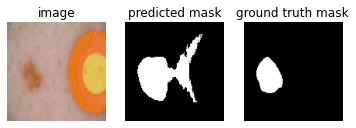

Epoch 46/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0381 - mean_iou: 0.9179 - false_positives: 126.5080 - false_negatives: 127.8171 - val_loss: 0.3701 - val_mean_iou: 0.7904 - val_false_positives: 161.2670 - val_false_negatives: 776.2993

Epoch 00046: val_mean_iou did not improve from 0.80946


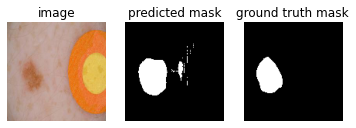

Epoch 47/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0526 - mean_iou: 0.8883 - false_positives: 178.4234 - false_negatives: 158.2782 - val_loss: 0.2684 - val_mean_iou: 0.8112 - val_false_positives: 319.4356 - val_false_negatives: 549.5890

Epoch 00047: val_mean_iou improved from 0.80946 to 0.81116, saving model to checkpoints/train_aug2/100


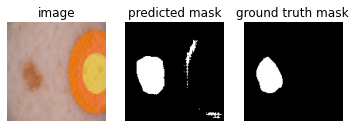

Epoch 48/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0488 - mean_iou: 0.8964 - false_positives: 165.5835 - false_negatives: 152.6295 - val_loss: 0.2815 - val_mean_iou: 0.7815 - val_false_positives: 241.8295 - val_false_negatives: 732.9583

Epoch 00048: val_mean_iou did not improve from 0.81116


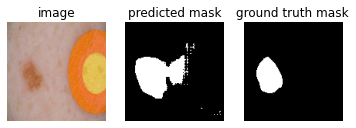

Epoch 49/100
193/193 [==============================] - 60s 312ms/step - loss: 0.0380 - mean_iou: 0.9145 - false_positives: 123.2330 - false_negatives: 126.3915 - val_loss: 0.2402 - val_mean_iou: 0.8137 - val_false_positives: 236.7064 - val_false_negatives: 608.9243

Epoch 00049: val_mean_iou improved from 0.81116 to 0.81372, saving model to checkpoints/train_aug2/100


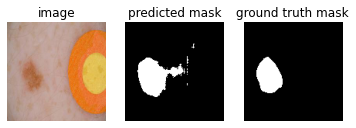

Epoch 50/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0556 - mean_iou: 0.8893 - false_positives: 185.2871 - false_negatives: 165.0451 - val_loss: 0.4794 - val_mean_iou: 0.6695 - val_false_positives: 1732.8372 - val_false_negatives: 283.5796

Epoch 00050: val_mean_iou did not improve from 0.81372


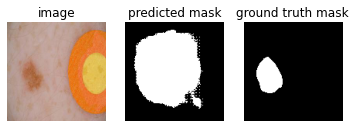

Epoch 51/100
193/193 [==============================] - 60s 309ms/step - loss: 0.1286 - mean_iou: 0.7620 - false_positives: 343.4376 - false_negatives: 379.6224 - val_loss: 0.5488 - val_mean_iou: 0.6938 - val_false_positives: 96.5758 - val_false_negatives: 1346.1193

Epoch 00051: val_mean_iou did not improve from 0.81372


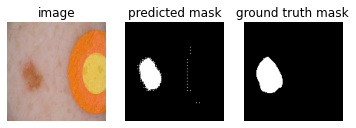

Epoch 52/100
193/193 [==============================] - 60s 310ms/step - loss: 0.1368 - mean_iou: 0.7729 - false_positives: 488.0237 - false_negatives: 321.3427 - val_loss: 0.3500 - val_mean_iou: 0.7477 - val_false_positives: 164.7008 - val_false_negatives: 982.8807

Epoch 00052: val_mean_iou did not improve from 0.81372


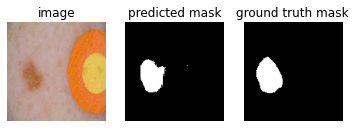

Epoch 53/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0612 - mean_iou: 0.8600 - false_positives: 179.3821 - false_negatives: 202.6652 - val_loss: 0.2228 - val_mean_iou: 0.8126 - val_false_positives: 319.0511 - val_false_negatives: 510.4659

Epoch 00053: val_mean_iou did not improve from 0.81372


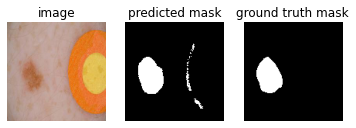

Epoch 54/100
193/193 [==============================] - 60s 308ms/step - loss: 0.0461 - mean_iou: 0.8949 - false_positives: 157.5489 - false_negatives: 145.3013 - val_loss: 0.3649 - val_mean_iou: 0.7857 - val_false_positives: 138.9792 - val_false_negatives: 830.4697

Epoch 00054: val_mean_iou did not improve from 0.81372


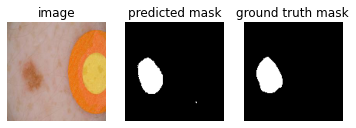

Epoch 55/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0388 - mean_iou: 0.9037 - false_positives: 124.3124 - false_negatives: 126.5697 - val_loss: 0.3057 - val_mean_iou: 0.7894 - val_false_positives: 271.3579 - val_false_negatives: 669.5360

Epoch 00055: val_mean_iou did not improve from 0.81372


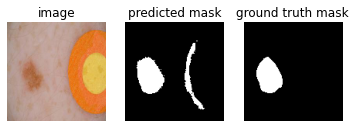

Epoch 56/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0437 - mean_iou: 0.8919 - false_positives: 135.4737 - false_negatives: 151.8691 - val_loss: 0.3339 - val_mean_iou: 0.7905 - val_false_positives: 155.2311 - val_false_negatives: 790.0985

Epoch 00056: val_mean_iou did not improve from 0.81372


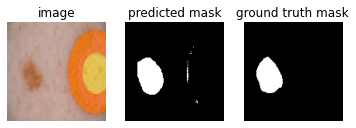

Epoch 57/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0322 - mean_iou: 0.9161 - false_positives: 103.4423 - false_negatives: 107.3294 - val_loss: 0.3506 - val_mean_iou: 0.8093 - val_false_positives: 200.9072 - val_false_negatives: 649.2784

Epoch 00057: val_mean_iou did not improve from 0.81372


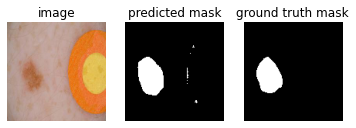

Epoch 58/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0312 - mean_iou: 0.9173 - false_positives: 102.3737 - false_negatives: 106.2914 - val_loss: 0.3765 - val_mean_iou: 0.7943 - val_false_positives: 157.8409 - val_false_negatives: 766.0776

Epoch 00058: val_mean_iou did not improve from 0.81372


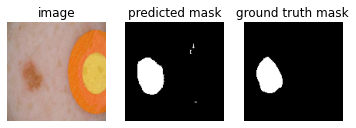

Epoch 59/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0603 - mean_iou: 0.8635 - false_positives: 211.0151 - false_negatives: 156.3445 - val_loss: 0.7866 - val_mean_iou: 0.6358 - val_false_positives: 51.0644 - val_false_negatives: 1642.1270

Epoch 00059: val_mean_iou did not improve from 0.81372


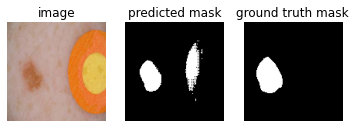

Epoch 60/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0902 - mean_iou: 0.8007 - false_positives: 276.2216 - false_negatives: 264.7052 - val_loss: 0.2687 - val_mean_iou: 0.8137 - val_false_positives: 246.8617 - val_false_negatives: 608.9659

Epoch 00060: val_mean_iou did not improve from 0.81372


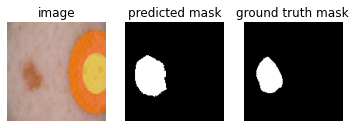

Epoch 61/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0373 - mean_iou: 0.8976 - false_positives: 123.0316 - false_negatives: 120.0568 - val_loss: 0.2967 - val_mean_iou: 0.8144 - val_false_positives: 251.1894 - val_false_negatives: 581.0947

Epoch 00061: val_mean_iou improved from 0.81372 to 0.81436, saving model to checkpoints/train_aug2/100


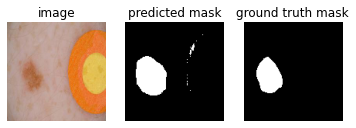

Epoch 62/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0434 - mean_iou: 0.8985 - false_positives: 147.5091 - false_negatives: 135.2477 - val_loss: 0.2844 - val_mean_iou: 0.8103 - val_false_positives: 296.8447 - val_false_negatives: 555.3030

Epoch 00062: val_mean_iou did not improve from 0.81436


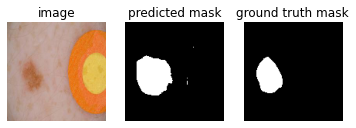

Epoch 63/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0301 - mean_iou: 0.9106 - false_positives: 104.0332 - false_negatives: 91.5546 - val_loss: 0.4178 - val_mean_iou: 0.7937 - val_false_positives: 162.8996 - val_false_negatives: 757.6534

Epoch 00063: val_mean_iou did not improve from 0.81436


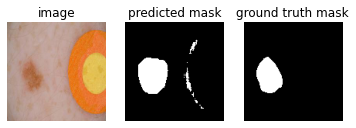

Epoch 64/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0394 - mean_iou: 0.9144 - false_positives: 124.0523 - false_negatives: 130.9782 - val_loss: 0.2870 - val_mean_iou: 0.8038 - val_false_positives: 315.1477 - val_false_negatives: 564.6212

Epoch 00064: val_mean_iou did not improve from 0.81436


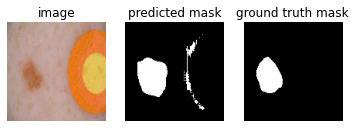

Epoch 65/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0368 - mean_iou: 0.8904 - false_positives: 131.7413 - false_negatives: 103.8175 - val_loss: 0.3820 - val_mean_iou: 0.7895 - val_false_positives: 116.1023 - val_false_negatives: 853.3561

Epoch 00065: val_mean_iou did not improve from 0.81436


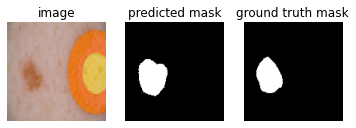

Epoch 66/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0590 - mean_iou: 0.8939 - false_positives: 202.2209 - false_negatives: 156.4313 - val_loss: 1.9679 - val_mean_iou: 0.3728 - val_false_positives: 201.7311 - val_false_negatives: 2899.1023

Epoch 00066: val_mean_iou did not improve from 0.81436


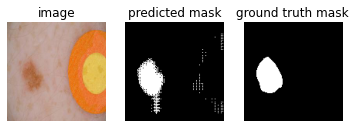

Epoch 67/100
193/193 [==============================] - 60s 310ms/step - loss: 0.2508 - mean_iou: 0.5651 - false_positives: 810.9147 - false_negatives: 486.8554 - val_loss: 0.2159 - val_mean_iou: 0.7773 - val_false_positives: 453.0076 - val_false_negatives: 576.1610

Epoch 00067: val_mean_iou did not improve from 0.81436


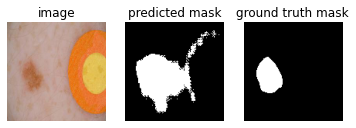

Epoch 68/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0804 - mean_iou: 0.8572 - false_positives: 226.3893 - false_negatives: 263.2258 - val_loss: 0.1855 - val_mean_iou: 0.7947 - val_false_positives: 518.9545 - val_false_negatives: 417.5985

Epoch 00068: val_mean_iou did not improve from 0.81436


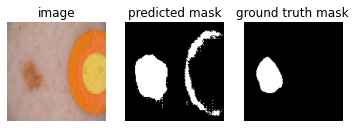

Epoch 69/100
193/193 [==============================] - 60s 308ms/step - loss: 0.0463 - mean_iou: 0.8741 - false_positives: 148.8684 - false_negatives: 145.0333 - val_loss: 0.3231 - val_mean_iou: 0.7999 - val_false_positives: 168.6383 - val_false_negatives: 742.7841

Epoch 00069: val_mean_iou did not improve from 0.81436


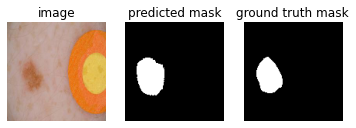

Epoch 70/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0558 - mean_iou: 0.8944 - false_positives: 192.9493 - false_negatives: 161.8118 - val_loss: 0.2197 - val_mean_iou: 0.7862 - val_false_positives: 384.5095 - val_false_negatives: 598.4924

Epoch 00070: val_mean_iou did not improve from 0.81436


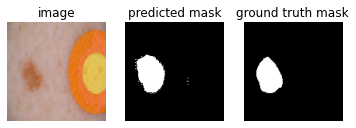

Epoch 71/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0554 - mean_iou: 0.8618 - false_positives: 198.0458 - false_negatives: 150.2933 - val_loss: 0.2843 - val_mean_iou: 0.8111 - val_false_positives: 253.6913 - val_false_negatives: 606.6193

Epoch 00071: val_mean_iou did not improve from 0.81436


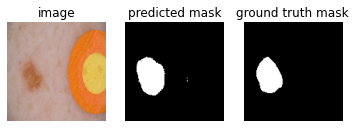

Epoch 72/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0514 - mean_iou: 0.9065 - false_positives: 168.4748 - false_negatives: 159.6045 - val_loss: 0.2214 - val_mean_iou: 0.8051 - val_false_positives: 517.0303 - val_false_negatives: 386.3390

Epoch 00072: val_mean_iou did not improve from 0.81436


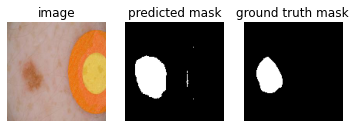

Epoch 73/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0359 - mean_iou: 0.9110 - false_positives: 136.6166 - false_negatives: 99.2184 - val_loss: 0.3190 - val_mean_iou: 0.8062 - val_false_positives: 188.5795 - val_false_negatives: 687.9470

Epoch 00073: val_mean_iou did not improve from 0.81436


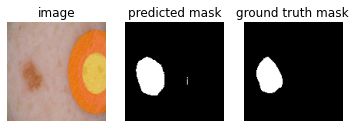

Epoch 74/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0390 - mean_iou: 0.9231 - false_positives: 133.9575 - false_negatives: 118.4344 - val_loss: 0.2614 - val_mean_iou: 0.8029 - val_false_positives: 526.0644 - val_false_negatives: 401.9110

Epoch 00074: val_mean_iou did not improve from 0.81436


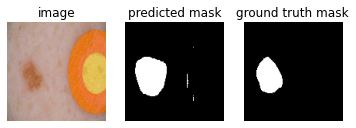

Epoch 75/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0352 - mean_iou: 0.9145 - false_positives: 130.7302 - false_negatives: 100.3801 - val_loss: 0.3333 - val_mean_iou: 0.8059 - val_false_positives: 180.2784 - val_false_negatives: 706.5947

Epoch 00075: val_mean_iou did not improve from 0.81436


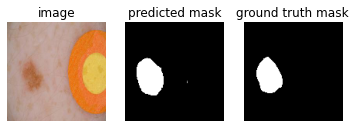

Epoch 76/100
193/193 [==============================] - 60s 308ms/step - loss: 0.0348 - mean_iou: 0.9274 - false_positives: 121.0919 - false_negatives: 106.6872 - val_loss: 0.2825 - val_mean_iou: 0.8088 - val_false_positives: 462.2102 - val_false_negatives: 418.3750

Epoch 00076: val_mean_iou did not improve from 0.81436


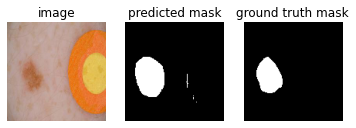

Epoch 77/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0322 - mean_iou: 0.9253 - false_positives: 121.1204 - false_negatives: 91.9454 - val_loss: 0.3753 - val_mean_iou: 0.7972 - val_false_positives: 171.3277 - val_false_negatives: 745.5549

Epoch 00077: val_mean_iou did not improve from 0.81436


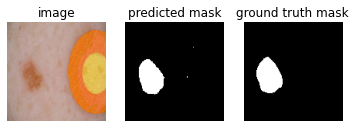

Epoch 78/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0450 - mean_iou: 0.9124 - false_positives: 165.9579 - false_negatives: 126.9751 - val_loss: 0.2615 - val_mean_iou: 0.8035 - val_false_positives: 395.9224 - val_false_negatives: 495.1591

Epoch 00078: val_mean_iou did not improve from 0.81436


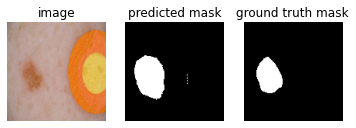

Epoch 79/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0484 - mean_iou: 0.8965 - false_positives: 176.9740 - false_negatives: 126.6416 - val_loss: 0.3019 - val_mean_iou: 0.8050 - val_false_positives: 195.2860 - val_false_negatives: 685.2349

Epoch 00079: val_mean_iou did not improve from 0.81436


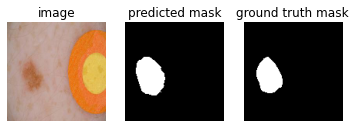

Epoch 80/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0382 - mean_iou: 0.9164 - false_positives: 129.5780 - false_negatives: 115.0771 - val_loss: 0.3043 - val_mean_iou: 0.8137 - val_false_positives: 285.1364 - val_false_negatives: 550.4091

Epoch 00080: val_mean_iou did not improve from 0.81436


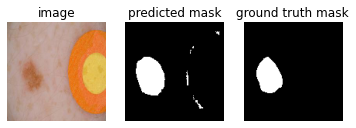

Epoch 81/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0713 - mean_iou: 0.8676 - false_positives: 234.4445 - false_negatives: 170.6821 - val_loss: 0.2833 - val_mean_iou: 0.7888 - val_false_positives: 262.3921 - val_false_negatives: 688.2140

Epoch 00081: val_mean_iou did not improve from 0.81436


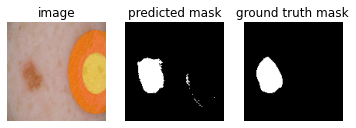

Epoch 82/100
193/193 [==============================] - 59s 308ms/step - loss: 0.0541 - mean_iou: 0.8807 - false_positives: 173.5900 - false_negatives: 164.9129 - val_loss: 0.2544 - val_mean_iou: 0.8145 - val_false_positives: 337.7405 - val_false_negatives: 497.0284

Epoch 00082: val_mean_iou improved from 0.81436 to 0.81447, saving model to checkpoints/train_aug2/100


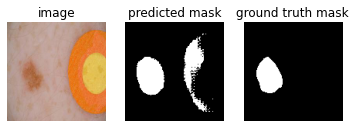

Epoch 83/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0406 - mean_iou: 0.9173 - false_positives: 138.5604 - false_negatives: 123.1053 - val_loss: 0.2865 - val_mean_iou: 0.8079 - val_false_positives: 299.2273 - val_false_negatives: 564.8314

Epoch 00083: val_mean_iou did not improve from 0.81447


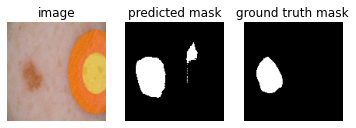

Epoch 84/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0335 - mean_iou: 0.9225 - false_positives: 116.1152 - false_negatives: 99.3227 - val_loss: 0.2964 - val_mean_iou: 0.8098 - val_false_positives: 354.2121 - val_false_negatives: 520.2746

Epoch 00084: val_mean_iou did not improve from 0.81447


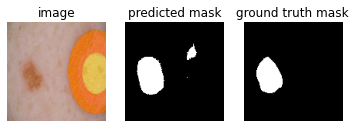

Epoch 85/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0356 - mean_iou: 0.9260 - false_positives: 119.8004 - false_negatives: 109.6796 - val_loss: 0.3417 - val_mean_iou: 0.8061 - val_false_positives: 210.7917 - val_false_negatives: 668.3920

Epoch 00085: val_mean_iou did not improve from 0.81447


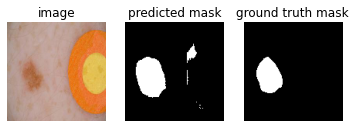

Epoch 86/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0288 - mean_iou: 0.9307 - false_positives: 99.0081 - false_negatives: 89.3906 - val_loss: 0.3713 - val_mean_iou: 0.8011 - val_false_positives: 254.2917 - val_false_negatives: 617.2273

Epoch 00086: val_mean_iou did not improve from 0.81447


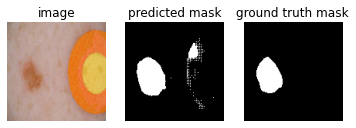

Epoch 87/100
193/193 [==============================] - 60s 309ms/step - loss: 0.0327 - mean_iou: 0.9248 - false_positives: 107.3780 - false_negatives: 106.0438 - val_loss: 0.3166 - val_mean_iou: 0.8096 - val_false_positives: 253.2178 - val_false_negatives: 600.8371

Epoch 00087: val_mean_iou did not improve from 0.81447


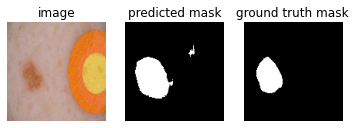

Epoch 88/100
193/193 [==============================] - 60s 310ms/step - loss: 0.0326 - mean_iou: 0.9211 - false_positives: 109.7309 - false_negatives: 101.4211 - val_loss: 0.3583 - val_mean_iou: 0.8055 - val_false_positives: 187.3485 - val_false_negatives: 687.5076

Epoch 00088: val_mean_iou did not improve from 0.81447


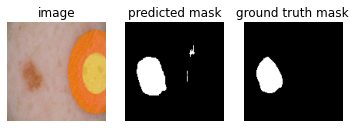

Epoch 89/100
193/193 [==============================] - 86s 446ms/step - loss: 0.0352 - mean_iou: 0.9127 - false_positives: 111.8964 - false_negatives: 115.6658 - val_loss: 0.3035 - val_mean_iou: 0.8110 - val_false_positives: 283.4337 - val_false_negatives: 563.8485

Epoch 00089: val_mean_iou did not improve from 0.81447


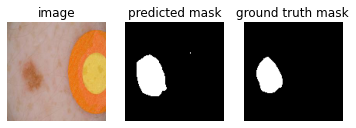

Epoch 90/100
193/193 [==============================] - 102s 527ms/step - loss: 0.0261 - mean_iou: 0.9309 - false_positives: 86.8175 - false_negatives: 83.3780 - val_loss: 0.4008 - val_mean_iou: 0.7975 - val_false_positives: 180.1989 - val_false_negatives: 740.3163

Epoch 00090: val_mean_iou did not improve from 0.81447


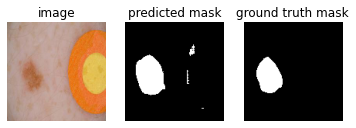

Epoch 91/100
193/193 [==============================] - 98s 511ms/step - loss: 0.0327 - mean_iou: 0.9101 - false_positives: 105.2010 - false_negatives: 105.2254 - val_loss: 0.2974 - val_mean_iou: 0.8101 - val_false_positives: 331.2424 - val_false_negatives: 517.1705

Epoch 00091: val_mean_iou did not improve from 0.81447


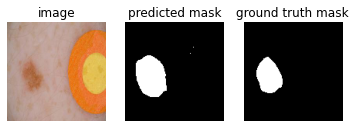

Epoch 92/100
193/193 [==============================] - 96s 498ms/step - loss: 0.0259 - mean_iou: 0.9278 - false_positives: 90.0731 - false_negatives: 80.2416 - val_loss: 0.3619 - val_mean_iou: 0.7959 - val_false_positives: 171.8106 - val_false_negatives: 740.2178

Epoch 00092: val_mean_iou did not improve from 0.81447


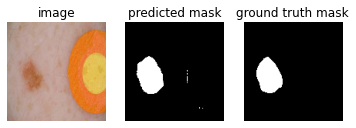

Epoch 93/100
193/193 [==============================] - 91s 473ms/step - loss: 0.0325 - mean_iou: 0.9162 - false_positives: 108.8625 - false_negatives: 102.0444 - val_loss: 0.2569 - val_mean_iou: 0.8082 - val_false_positives: 412.1155 - val_false_negatives: 460.0019

Epoch 00093: val_mean_iou did not improve from 0.81447


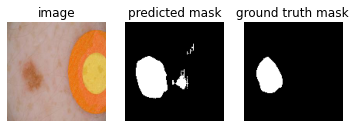

Epoch 94/100
193/193 [==============================] - 99s 516ms/step - loss: 0.0264 - mean_iou: 0.9256 - false_positives: 87.3582 - false_negatives: 85.2620 - val_loss: 0.4068 - val_mean_iou: 0.8024 - val_false_positives: 165.3958 - val_false_negatives: 723.6629

Epoch 00094: val_mean_iou did not improve from 0.81447


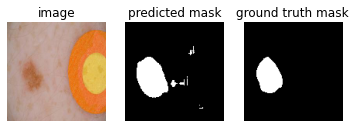

Epoch 95/100
193/193 [==============================] - 104s 538ms/step - loss: 0.0279 - mean_iou: 0.9346 - false_positives: 88.0016 - false_negatives: 93.6692 - val_loss: 0.2516 - val_mean_iou: 0.8126 - val_false_positives: 478.6193 - val_false_negatives: 382.1837

Epoch 00095: val_mean_iou did not improve from 0.81447


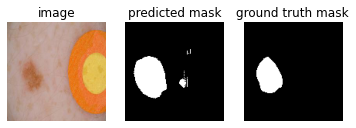

Epoch 96/100
193/193 [==============================] - 102s 531ms/step - loss: 0.0217 - mean_iou: 0.9346 - false_positives: 76.4559 - false_negatives: 64.7050 - val_loss: 0.4372 - val_mean_iou: 0.8027 - val_false_positives: 174.8883 - val_false_negatives: 713.7955

Epoch 00096: val_mean_iou did not improve from 0.81447


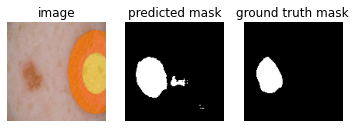

Epoch 97/100
193/193 [==============================] - 102s 529ms/step - loss: 0.0293 - mean_iou: 0.9334 - false_positives: 93.7152 - false_negatives: 96.7916 - val_loss: 0.2807 - val_mean_iou: 0.8071 - val_false_positives: 492.4943 - val_false_negatives: 387.4015

Epoch 00097: val_mean_iou did not improve from 0.81447


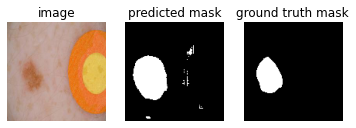

Epoch 98/100
193/193 [==============================] - 102s 529ms/step - loss: 0.0271 - mean_iou: 0.9201 - false_positives: 95.2321 - false_negatives: 79.2802 - val_loss: 0.4042 - val_mean_iou: 0.8018 - val_false_positives: 183.4735 - val_false_negatives: 709.8295

Epoch 00098: val_mean_iou did not improve from 0.81447


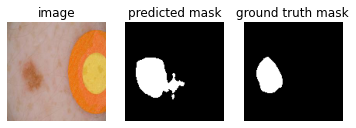

Epoch 99/100
193/193 [==============================] - 102s 529ms/step - loss: 0.0304 - mean_iou: 0.9355 - false_positives: 104.5039 - false_negatives: 94.2187 - val_loss: 0.2717 - val_mean_iou: 0.8077 - val_false_positives: 497.9375 - val_false_negatives: 382.7595

Epoch 00099: val_mean_iou did not improve from 0.81447


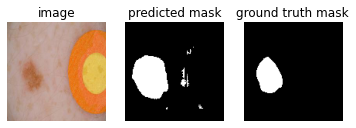

Epoch 100/100
193/193 [==============================] - 106s 548ms/step - loss: 0.0228 - mean_iou: 0.9293 - false_positives: 82.8718 - false_negatives: 66.5968 - val_loss: 0.3971 - val_mean_iou: 0.8055 - val_false_positives: 202.9375 - val_false_negatives: 686.9697

Epoch 00100: val_mean_iou did not improve from 0.81447


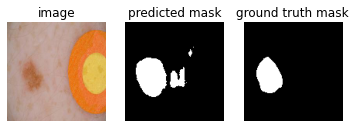

In [28]:
model.fit(train_data,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=validation_data,
          shuffle=True,
          steps_per_epoch=ceil(TRAIN_COUNT/BATCH_SIZE),
          validation_steps=ceil(VALIDATION_COUNT/BATCH_SIZE),
          callbacks=[best_checkpoint, image_callback, board_callback],
          initial_epoch=22
          )

In [29]:
%load_ext tensorboard
%tensorboard --logdir logs/train_aug2

## Evaluate pix2pix2 augmented model on test images<a name='evaluate_augment_pix2pix_no_jittering'></a>

In [30]:
TEST_DIR = '../../test_dataset/'

flow_args = {k: v for k, v in flow_args.items()}
flow_args['shuffle'] = False

test_generator = zip(
    image_generator.flow_from_directory(
        directory=TEST_DIR,
        classes=['image'],
        color_mode='rgb',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TEST_DIR,
        classes=['mask'],
        color_mode='grayscale',
        **flow_args
    )
)

test_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, test_generator),
    **dataset_args
)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [ ]:
TEST_COUNT = 100

model = get_model(
    optimizer=tf.keras.optimizers.Adam,
    learning_rate=1e-3,
    dropout_rate=0.4
)

model.load_weights(f'checkpoints/train_aug2/100')

evaluate = model.evaluate(
    test_data,
    steps=ceil(TEST_COUNT/BATCH_SIZE),
    return_dict=True
)

iou = evaluate['mean_iou']
fp = evaluate['false_positives']
fn = evaluate['false_negatives']

print()
print(f'Test mean IoU: {iou:.2f}')
print(f'Test mean false positives: {fp:.2f}')
print(f'Test mean false negatives: {fn:.2f}')

## Train U-net on data augmented with Pix2Pix3 (no jittering)<a name='augment_pix2pix_no_jittering'></a>

3594 training (2594 real and 1000 synthetic) are used during training

In [20]:
from itertools import chain

In [21]:
BATCH_SIZE = 16

flow_args = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'target_size': (128, 128),
    'class_mode': None,
    'seed': 1
}

TRAIN_DIR = '../../dataset'

train_generator = zip(
    image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['image'],
        color_mode='rgb',
        subset='training',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['mask'],
        color_mode='grayscale',
        subset='training',
        **flow_args
    )
)

train_generator = chain(train_generator,
                        zip(
                            image_generator.flow_from_directory(
                                directory=TRAIN_DIR,
                                classes=['image_aug3'],
                                color_mode='rgb',
                                **flow_args
                            ),
                            mask_generator.flow_from_directory(
                                directory=TRAIN_DIR,
                                classes=['mask_aug3'],
                                color_mode='grayscale',
                                **flow_args
                            )
                        )
                        )

validation_generator = zip(
    image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['image'],
        color_mode='rgb',
        subset='validation',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['mask'],
        color_mode='grayscale',
        subset='validation',
        **flow_args
    )
)

dataset_args = {
    'output_types': (tf.float32,) * 2,
    'output_shapes': ([None, 128, 128, 3], [None, 128, 128, 1])
}

train_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, train_generator),
    **dataset_args
)

validation_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, validation_generator),
    **dataset_args
)

Found 2076 images belonging to 1 classes.
Found 2076 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 518 images belonging to 1 classes.
Found 518 images belonging to 1 classes.


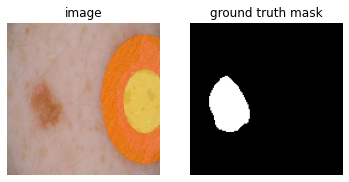

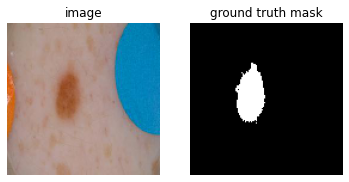

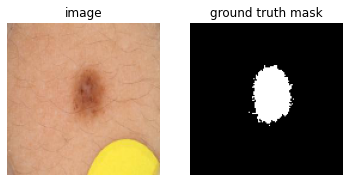

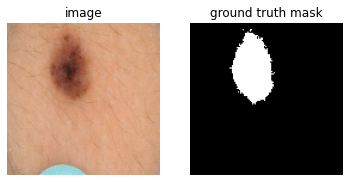

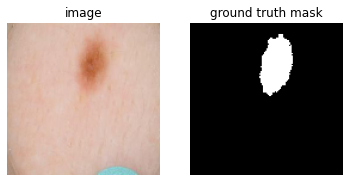

In [22]:
# Check images and masks are loaded properly
images, masks = next(train_generator)

for i, m in list(zip(images, masks))[:5]:
    _, axarr = plt.subplots(1, 2)

    plot_args = {
        'title': ['image', 'ground truth mask'],
        'args': [
            {'X': denormalize(i)},
            {'X': m[:, :, 0], 'cmap': 'gray'},
        ]
    }

    for ax, t, a in zip(axarr, plot_args['title'], plot_args['args']):
        ax.set_title(t)
        fig = ax.imshow(**a)
        ax.axis('off')
    plt.show()

In [23]:
TRAIN_COUNT = 3076
VALIDATION_COUNT = 518
EPOCHS = 100

In [24]:
model = get_model(
    optimizer=tf.keras.optimizers.Adam,
    learning_rate=1e-3,
    dropout_rate=0.4
)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 64, 64, 64)   3072        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 32, 32, 128)  131072      sequential_13[0][0]              
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 16, 16, 256)  525312      sequential_14[0][0]              
____________________________________________________________________________________________

In [25]:
CHECKPOINT_PATH = f'checkpoints/train_aug3/100'
    
best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{CHECKPOINT_PATH}',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_mean_iou',
    mode='max',
    verbose=1
)

image_callback = ImageCallback(model)

LOG_DIR = f'logs/train_aug3'
board_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

In [26]:
model.load_weights(f'checkpoints/train_aug3/100')

Epoch 88/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpdvrbq5zl.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpdvrbq5zl.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmppssyrlzq.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity

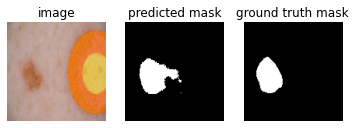

Epoch 89/100
193/193 [==============================] - 50s 259ms/step - loss: 0.0480 - mean_iou: 0.8864 - false_positives: 156.9464 - false_negatives: 144.9119 - val_loss: 0.2922 - val_mean_iou: 0.8080 - val_false_positives: 194.1004 - val_false_negatives: 677.3693

Epoch 00089: val_mean_iou improved from 0.78773 to 0.80798, saving model to checkpoints/train_aug3/100


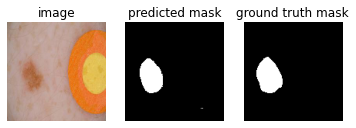

Epoch 90/100
193/193 [==============================] - 50s 259ms/step - loss: 0.0370 - mean_iou: 0.9066 - false_positives: 121.9741 - false_negatives: 118.8285 - val_loss: 0.2844 - val_mean_iou: 0.8040 - val_false_positives: 207.2064 - val_false_negatives: 671.1477

Epoch 00090: val_mean_iou did not improve from 0.80798


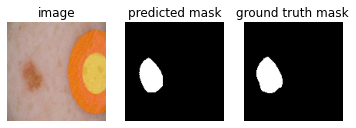

Epoch 91/100
193/193 [==============================] - 50s 259ms/step - loss: 0.0317 - mean_iou: 0.9162 - false_positives: 105.0455 - false_negatives: 101.1521 - val_loss: 0.3731 - val_mean_iou: 0.8048 - val_false_positives: 167.8958 - val_false_negatives: 709.5663

Epoch 00091: val_mean_iou did not improve from 0.80798


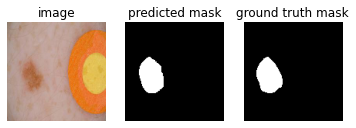

Epoch 92/100
193/193 [==============================] - 50s 260ms/step - loss: 0.0290 - mean_iou: 0.9196 - false_positives: 96.7522 - false_negatives: 93.7980 - val_loss: 0.3002 - val_mean_iou: 0.8108 - val_false_positives: 269.1534 - val_false_negatives: 582.1799

Epoch 00092: val_mean_iou improved from 0.80798 to 0.81077, saving model to checkpoints/train_aug3/100


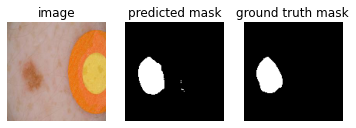

Epoch 93/100
193/193 [==============================] - 50s 260ms/step - loss: 0.0354 - mean_iou: 0.9147 - false_positives: 116.4370 - false_negatives: 97.7428 - val_loss: 0.4345 - val_mean_iou: 0.7774 - val_false_positives: 151.8674 - val_false_negatives: 841.0322

Epoch 00093: val_mean_iou did not improve from 0.81077


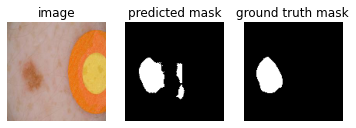

Epoch 94/100
193/193 [==============================] - 50s 260ms/step - loss: 0.0390 - mean_iou: 0.9077 - false_positives: 135.9944 - false_negatives: 116.6108 - val_loss: 0.2489 - val_mean_iou: 0.8078 - val_false_positives: 365.0493 - val_false_negatives: 489.2917

Epoch 00094: val_mean_iou did not improve from 0.81077


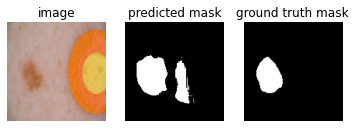

Epoch 95/100
193/193 [==============================] - 50s 260ms/step - loss: 0.0275 - mean_iou: 0.9184 - false_positives: 101.2065 - false_negatives: 80.5363 - val_loss: 0.4249 - val_mean_iou: 0.7998 - val_false_positives: 152.8655 - val_false_negatives: 755.3447

Epoch 00095: val_mean_iou did not improve from 0.81077


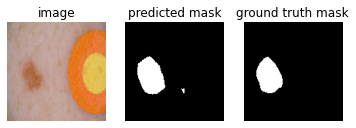

Epoch 96/100
193/193 [==============================] - 50s 261ms/step - loss: 0.0296 - mean_iou: 0.9318 - false_positives: 97.6664 - false_negatives: 93.9200 - val_loss: 0.3427 - val_mean_iou: 0.8058 - val_false_positives: 293.6440 - val_false_negatives: 570.9394

Epoch 00096: val_mean_iou did not improve from 0.81077


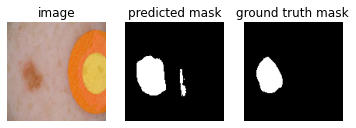

Epoch 97/100
193/193 [==============================] - 50s 261ms/step - loss: 0.0219 - mean_iou: 0.9349 - false_positives: 76.3439 - false_negatives: 67.2804 - val_loss: 0.4288 - val_mean_iou: 0.7995 - val_false_positives: 164.5814 - val_false_negatives: 740.2026

Epoch 00097: val_mean_iou did not improve from 0.81077


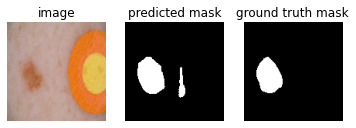

Epoch 98/100
193/193 [==============================] - 50s 261ms/step - loss: 0.1164 - mean_iou: 0.7927 - false_positives: 381.5360 - false_negatives: 233.0368 - val_loss: 0.2353 - val_mean_iou: 0.7970 - val_false_positives: 456.0644 - val_false_negatives: 466.1099

Epoch 00098: val_mean_iou did not improve from 0.81077


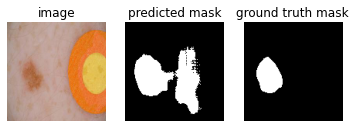

Epoch 99/100
193/193 [==============================] - 50s 261ms/step - loss: 0.0345 - mean_iou: 0.9030 - false_positives: 119.1840 - false_negatives: 95.6015 - val_loss: 0.4020 - val_mean_iou: 0.7901 - val_false_positives: 182.4830 - val_false_negatives: 758.4186

Epoch 00099: val_mean_iou did not improve from 0.81077


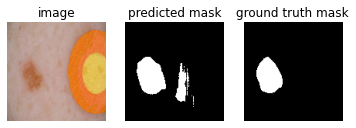

Epoch 100/100
193/193 [==============================] - 50s 261ms/step - loss: 0.0384 - mean_iou: 0.9264 - false_positives: 119.4088 - false_negatives: 118.4278 - val_loss: 0.2418 - val_mean_iou: 0.8088 - val_false_positives: 406.5663 - val_false_negatives: 463.8788

Epoch 00100: val_mean_iou did not improve from 0.81077


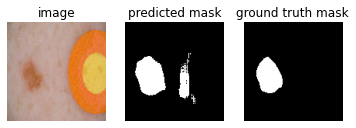

In [27]:
model.fit(train_data,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=validation_data,
          shuffle=True,
          steps_per_epoch=ceil(TRAIN_COUNT/BATCH_SIZE),
          validation_steps=ceil(VALIDATION_COUNT/BATCH_SIZE),
          callbacks=[best_checkpoint, image_callback, board_callback],
          initial_epoch=87
          )

In [28]:
%load_ext tensorboard
%tensorboard --logdir logs/train_aug3

## Evaluate pix2pix3 augmented model on test images<a name='evaluate_augment_pix2pix_no_jittering'></a>

In [28]:
TEST_DIR = '../../test_dataset/'

flow_args = {k: v for k, v in flow_args.items()}
flow_args['shuffle'] = False

test_generator = zip(
    image_generator.flow_from_directory(
        directory=TEST_DIR,
        classes=['image'],
        color_mode='rgb',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TEST_DIR,
        classes=['mask'],
        color_mode='grayscale',
        **flow_args
    )
)

test_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, test_generator),
    **dataset_args
)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [29]:
TEST_COUNT = 100

model = get_model(
    optimizer=tf.keras.optimizers.Adam,
    learning_rate=1e-3,
    dropout_rate=0.4
)

model.load_weights(f'checkpoints/train_aug3/100')

evaluate = model.evaluate(
    test_data,
    steps=ceil(TEST_COUNT/BATCH_SIZE),
    return_dict=True
)

iou = evaluate['mean_iou']
fp = evaluate['false_positives']
fn = evaluate['false_negatives']

print()
print(f'Test mean IoU: {iou:.2f}')
print(f'Test mean false positives: {fp:.2f}')
print(f'Test mean false negatives: {fn:.2f}')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_26 (Sequential)      (None, 64, 64, 64)   3072        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_27 (Sequential)      (None, 32, 32, 128)  131072      sequential_26[0][0]              
__________________________________________________________________________________________________
sequential_28 (Sequential)      (None, 16, 16, 256)  525312      sequential_27[0][0]              
____________________________________________________________________________________________

## Train U-net on data augmented with Pix2Pix4 (no jittering)<a name='augment_pix2pix_no_jittering'></a>

3594 training (2594 real and 1000 synthetic) are used during training

In [20]:
from itertools import chain

In [21]:
BATCH_SIZE = 16

flow_args = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'target_size': (128, 128),
    'class_mode': None,
    'seed': 1
}

TRAIN_DIR = '../../dataset'

train_generator = zip(
    image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['image'],
        color_mode='rgb',
        subset='training',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['mask'],
        color_mode='grayscale',
        subset='training',
        **flow_args
    )
)

train_generator = chain(train_generator,
                        zip(
                            image_generator.flow_from_directory(
                                directory=TRAIN_DIR,
                                classes=['image_aug4'],
                                color_mode='rgb',
                                **flow_args
                            ),
                            mask_generator.flow_from_directory(
                                directory=TRAIN_DIR,
                                classes=['mask_aug4'],
                                color_mode='grayscale',
                                **flow_args
                            )
                        )
                        )

validation_generator = zip(
    image_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['image'],
        color_mode='rgb',
        subset='validation',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TRAIN_DIR,
        classes=['mask'],
        color_mode='grayscale',
        subset='validation',
        **flow_args
    )
)

dataset_args = {
    'output_types': (tf.float32,) * 2,
    'output_shapes': ([None, 128, 128, 3], [None, 128, 128, 1])
}

train_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, train_generator),
    **dataset_args
)

validation_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, validation_generator),
    **dataset_args
)

Found 2076 images belonging to 1 classes.
Found 2076 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 2594 images belonging to 1 classes.
Found 518 images belonging to 1 classes.
Found 518 images belonging to 1 classes.


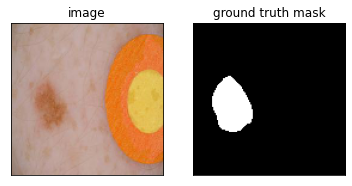

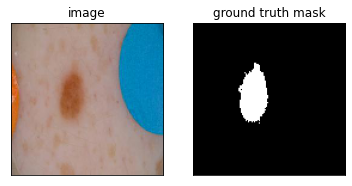

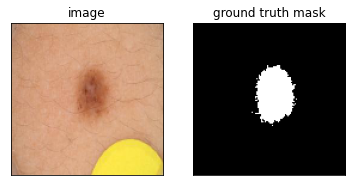

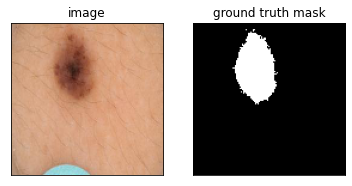

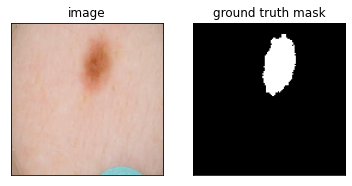

In [22]:
# Check images and masks are loaded properly
images, masks = next(train_generator)

for i, m in list(zip(images, masks))[:5]:
    _, axarr = plt.subplots(1, 2)

    plot_args = {
        'title': ['image', 'ground truth mask'],
        'args': [
            {'X': denormalize(i)},
            {'X': m[:, :, 0], 'cmap': 'gray'},
        ]
    }

    for ax, t, a in zip(axarr, plot_args['title'], plot_args['args']):
        ax.set_title(t)
        fig = ax.imshow(**a)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [23]:
TRAIN_COUNT = 3076
VALIDATION_COUNT = 518
EPOCHS = 100

In [24]:
model = get_model(
    optimizer=tf.keras.optimizers.Adam,
    learning_rate=1e-3,
    dropout_rate=0.4
)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 64, 64, 64)   3072        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 32, 32, 128)  131072      sequential_13[0][0]              
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 16, 16, 256)  525312      sequential_14[0][0]              
____________________________________________________________________________________________

In [25]:
CHECKPOINT_PATH = f'checkpoints/train_aug4/100'
    
best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{CHECKPOINT_PATH}',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_mean_iou',
    mode='max',
    verbose=1
)

image_callback = ImageCallback(model)

LOG_DIR = f'logs/train_aug4'
board_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

In [26]:
model.load_weights(f'checkpoints/train_aug4/100')

Epoch 30/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpmpkxl3gl.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpmpkxl3gl.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmprpdz3_6h.py, line 10)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity

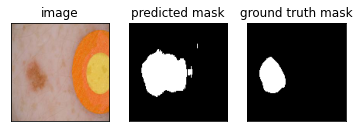

Epoch 31/100
193/193 [==============================] - 50s 259ms/step - loss: 0.0807 - mean_iou: 0.8224 - false_positives: 230.3450 - false_negatives: 266.7854 - val_loss: 0.1780 - val_mean_iou: 0.7890 - val_false_positives: 580.7273 - val_false_negatives: 395.0454

Epoch 00031: val_mean_iou improved from 0.75596 to 0.78900, saving model to checkpoints/train_aug4/100


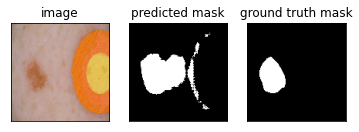

Epoch 32/100
193/193 [==============================] - 50s 260ms/step - loss: 0.0844 - mean_iou: 0.8139 - false_positives: 257.0116 - false_negatives: 259.9532 - val_loss: 0.2931 - val_mean_iou: 0.7175 - val_false_positives: 163.8144 - val_false_negatives: 1117.5605

Epoch 00032: val_mean_iou did not improve from 0.78900


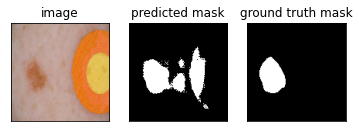

Epoch 33/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0900 - mean_iou: 0.7865 - false_positives: 229.4905 - false_negatives: 319.5615 - val_loss: 0.1849 - val_mean_iou: 0.7935 - val_false_positives: 489.3466 - val_false_negatives: 449.4810

Epoch 00033: val_mean_iou improved from 0.78900 to 0.79345, saving model to checkpoints/train_aug4/100


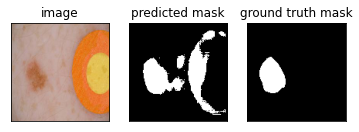

Epoch 34/100
193/193 [==============================] - 50s 261ms/step - loss: 0.0730 - mean_iou: 0.8135 - false_positives: 215.7869 - false_negatives: 251.9821 - val_loss: 0.2507 - val_mean_iou: 0.7677 - val_false_positives: 219.8068 - val_false_negatives: 822.0455

Epoch 00034: val_mean_iou did not improve from 0.79345


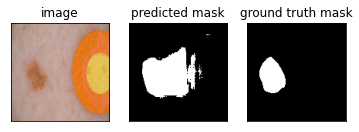

Epoch 35/100
193/193 [==============================] - 50s 261ms/step - loss: 0.0575 - mean_iou: 0.8415 - false_positives: 170.2648 - false_negatives: 202.3218 - val_loss: 0.2743 - val_mean_iou: 0.8029 - val_false_positives: 231.9621 - val_false_negatives: 652.2349

Epoch 00035: val_mean_iou improved from 0.79345 to 0.80288, saving model to checkpoints/train_aug4/100


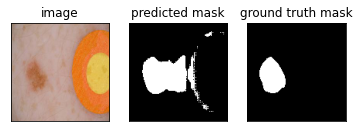

Epoch 36/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0518 - mean_iou: 0.8765 - false_positives: 145.8232 - false_negatives: 191.9944 - val_loss: 0.2912 - val_mean_iou: 0.7902 - val_false_positives: 155.6042 - val_false_negatives: 801.0417

Epoch 00036: val_mean_iou did not improve from 0.80288


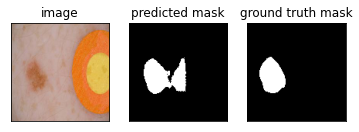

Epoch 37/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0411 - mean_iou: 0.8805 - false_positives: 124.0956 - false_negatives: 152.8590 - val_loss: 0.3377 - val_mean_iou: 0.7912 - val_false_positives: 206.0133 - val_false_negatives: 722.1629

Epoch 00037: val_mean_iou did not improve from 0.80288


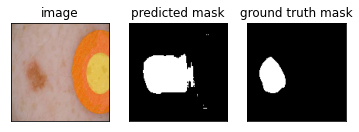

Epoch 38/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0506 - mean_iou: 0.8856 - false_positives: 136.1798 - false_negatives: 202.8295 - val_loss: 0.2383 - val_mean_iou: 0.7724 - val_false_positives: 221.9848 - val_false_negatives: 800.6724

Epoch 00038: val_mean_iou did not improve from 0.80288


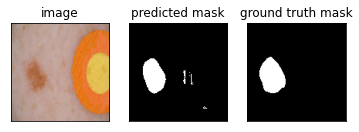

Epoch 39/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0504 - mean_iou: 0.8466 - false_positives: 159.0727 - false_negatives: 172.9189 - val_loss: 0.3010 - val_mean_iou: 0.7991 - val_false_positives: 190.5549 - val_false_negatives: 725.7879

Epoch 00039: val_mean_iou did not improve from 0.80288


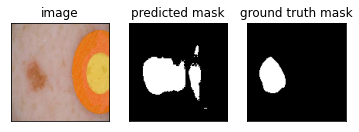

Epoch 40/100
193/193 [==============================] - 51s 266ms/step - loss: 0.0891 - mean_iou: 0.8465 - false_positives: 252.9987 - false_negatives: 257.3949 - val_loss: 0.2476 - val_mean_iou: 0.7521 - val_false_positives: 661.2746 - val_false_negatives: 600.6818

Epoch 00040: val_mean_iou did not improve from 0.80288


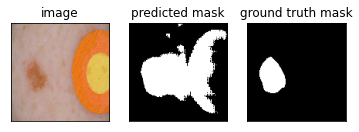

Epoch 41/100
193/193 [==============================] - 51s 266ms/step - loss: 0.0601 - mean_iou: 0.8293 - false_positives: 176.9655 - false_negatives: 200.9550 - val_loss: 0.2851 - val_mean_iou: 0.7966 - val_false_positives: 233.9735 - val_false_negatives: 676.0493

Epoch 00041: val_mean_iou did not improve from 0.80288


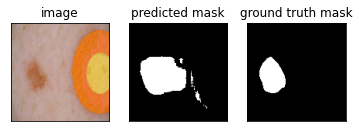

Epoch 42/100
193/193 [==============================] - 51s 266ms/step - loss: 0.0543 - mean_iou: 0.8920 - false_positives: 154.8722 - false_negatives: 202.6022 - val_loss: 0.2697 - val_mean_iou: 0.7896 - val_false_positives: 156.8277 - val_false_negatives: 797.3144

Epoch 00042: val_mean_iou did not improve from 0.80288


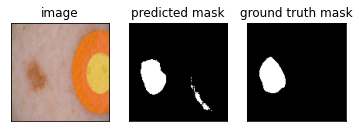

Epoch 43/100
193/193 [==============================] - 51s 267ms/step - loss: 0.0409 - mean_iou: 0.8782 - false_positives: 122.1885 - false_negatives: 143.6514 - val_loss: 0.2801 - val_mean_iou: 0.8081 - val_false_positives: 207.6193 - val_false_negatives: 652.9356

Epoch 00043: val_mean_iou improved from 0.80288 to 0.80807, saving model to checkpoints/train_aug4/100


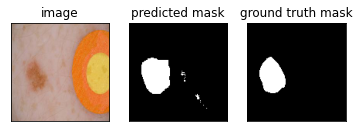

Epoch 44/100
193/193 [==============================] - 51s 266ms/step - loss: 0.0461 - mean_iou: 0.9039 - false_positives: 141.1918 - false_negatives: 168.3561 - val_loss: 0.2575 - val_mean_iou: 0.8095 - val_false_positives: 259.8579 - val_false_negatives: 607.4337

Epoch 00044: val_mean_iou improved from 0.80807 to 0.80946, saving model to checkpoints/train_aug4/100


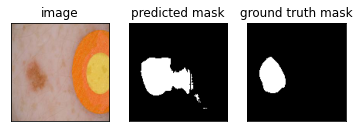

Epoch 45/100
193/193 [==============================] - 51s 266ms/step - loss: 0.0363 - mean_iou: 0.8973 - false_positives: 121.4783 - false_negatives: 121.6811 - val_loss: 0.3384 - val_mean_iou: 0.8003 - val_false_positives: 149.8125 - val_false_negatives: 768.4261

Epoch 00045: val_mean_iou did not improve from 0.80946


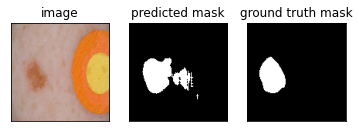

Epoch 46/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0480 - mean_iou: 0.9093 - false_positives: 142.8054 - false_negatives: 175.3562 - val_loss: 0.2379 - val_mean_iou: 0.8008 - val_false_positives: 233.5549 - val_false_negatives: 659.8239

Epoch 00046: val_mean_iou did not improve from 0.80946


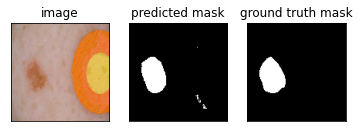

Epoch 47/100
193/193 [==============================] - 51s 265ms/step - loss: 0.0390 - mean_iou: 0.8994 - false_positives: 122.0101 - false_negatives: 137.2470 - val_loss: 0.3002 - val_mean_iou: 0.7912 - val_false_positives: 244.2292 - val_false_negatives: 709.6364

Epoch 00047: val_mean_iou did not improve from 0.80946


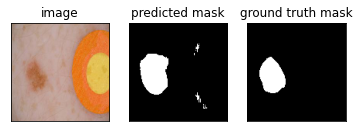

Epoch 48/100
193/193 [==============================] - 51s 267ms/step - loss: 0.1382 - mean_iou: 0.7873 - false_positives: 409.0483 - false_negatives: 379.3738 - val_loss: 0.2304 - val_mean_iou: 0.8061 - val_false_positives: 350.2046 - val_false_negatives: 557.0511

Epoch 00048: val_mean_iou did not improve from 0.80946


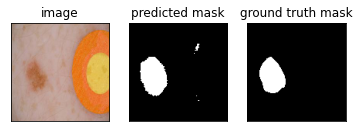

Epoch 49/100
193/193 [==============================] - 52s 268ms/step - loss: 0.0609 - mean_iou: 0.8642 - false_positives: 182.5592 - false_negatives: 198.4609 - val_loss: 0.2931 - val_mean_iou: 0.7841 - val_false_positives: 231.9148 - val_false_negatives: 727.8845

Epoch 00049: val_mean_iou did not improve from 0.80946


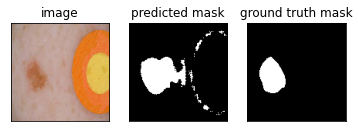

Epoch 50/100
193/193 [==============================] - 52s 268ms/step - loss: 0.0495 - mean_iou: 0.9019 - false_positives: 152.9819 - false_negatives: 167.7201 - val_loss: 0.2395 - val_mean_iou: 0.8073 - val_false_positives: 321.9526 - val_false_negatives: 555.5474

Epoch 00050: val_mean_iou did not improve from 0.80946


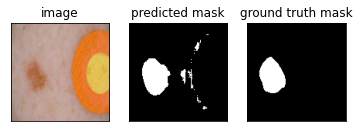

Epoch 51/100
193/193 [==============================] - 52s 272ms/step - loss: 0.0414 - mean_iou: 0.9034 - false_positives: 142.1734 - false_negatives: 131.6918 - val_loss: 0.3813 - val_mean_iou: 0.7843 - val_false_positives: 134.8769 - val_false_negatives: 845.1780

Epoch 00051: val_mean_iou did not improve from 0.80946


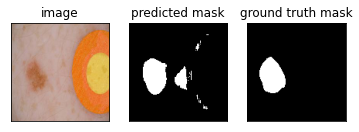

Epoch 52/100
193/193 [==============================] - 53s 273ms/step - loss: 0.0437 - mean_iou: 0.9077 - false_positives: 140.0983 - false_negatives: 146.6533 - val_loss: 0.2535 - val_mean_iou: 0.8034 - val_false_positives: 345.2651 - val_false_negatives: 554.6212

Epoch 00052: val_mean_iou did not improve from 0.80946


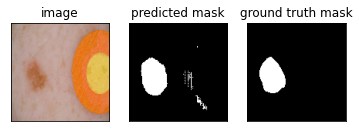

Epoch 53/100
193/193 [==============================] - 53s 274ms/step - loss: 0.0456 - mean_iou: 0.8952 - false_positives: 145.0469 - false_negatives: 147.5498 - val_loss: 0.3291 - val_mean_iou: 0.7735 - val_false_positives: 113.4754 - val_false_negatives: 906.3428

Epoch 00053: val_mean_iou did not improve from 0.80946


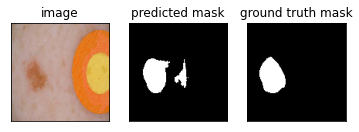

Epoch 54/100
193/193 [==============================] - 52s 269ms/step - loss: 0.0401 - mean_iou: 0.9105 - false_positives: 131.6922 - false_negatives: 133.9652 - val_loss: 0.2832 - val_mean_iou: 0.8039 - val_false_positives: 284.3599 - val_false_negatives: 606.2064

Epoch 00054: val_mean_iou did not improve from 0.80946


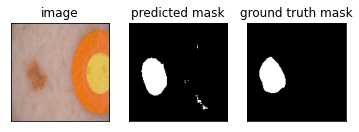

Epoch 55/100
193/193 [==============================] - 52s 269ms/step - loss: 0.0365 - mean_iou: 0.9205 - false_positives: 125.2634 - false_negatives: 119.9212 - val_loss: 0.4018 - val_mean_iou: 0.7775 - val_false_positives: 142.8580 - val_false_negatives: 859.6780

Epoch 00055: val_mean_iou did not improve from 0.80946


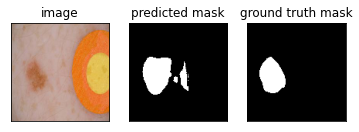

Epoch 56/100
193/193 [==============================] - 52s 268ms/step - loss: 0.0388 - mean_iou: 0.9076 - false_positives: 122.7070 - false_negatives: 131.3624 - val_loss: 0.2983 - val_mean_iou: 0.7965 - val_false_positives: 169.5473 - val_false_negatives: 765.8409

Epoch 00056: val_mean_iou did not improve from 0.80946


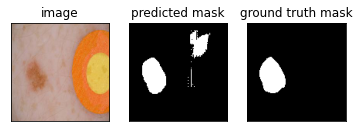

Epoch 57/100
193/193 [==============================] - 53s 276ms/step - loss: 0.0498 - mean_iou: 0.8959 - false_positives: 151.9652 - false_negatives: 172.6624 - val_loss: 0.3469 - val_mean_iou: 0.7737 - val_false_positives: 193.7727 - val_false_negatives: 822.0000

Epoch 00057: val_mean_iou did not improve from 0.80946


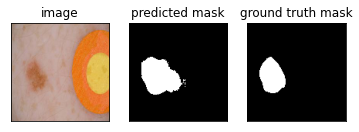

Epoch 58/100
193/193 [==============================] - 53s 273ms/step - loss: 0.0437 - mean_iou: 0.9016 - false_positives: 133.5079 - false_negatives: 149.8022 - val_loss: 0.2485 - val_mean_iou: 0.8050 - val_false_positives: 229.6061 - val_false_negatives: 642.2955

Epoch 00058: val_mean_iou did not improve from 0.80946


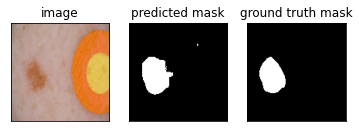

Epoch 59/100
193/193 [==============================] - 51s 266ms/step - loss: 0.0404 - mean_iou: 0.9189 - false_positives: 127.3631 - false_negatives: 141.5160 - val_loss: 0.3736 - val_mean_iou: 0.7854 - val_false_positives: 135.4015 - val_false_negatives: 836.5246

Epoch 00059: val_mean_iou did not improve from 0.80946


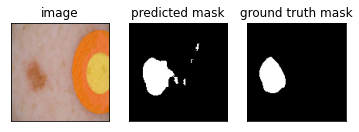

Epoch 60/100
193/193 [==============================] - 51s 265ms/step - loss: 0.0341 - mean_iou: 0.9187 - false_positives: 105.6023 - false_negatives: 121.1549 - val_loss: 0.3398 - val_mean_iou: 0.7838 - val_false_positives: 234.3485 - val_false_negatives: 740.8049

Epoch 00060: val_mean_iou did not improve from 0.80946


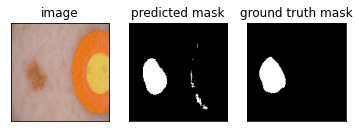

Epoch 61/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0792 - mean_iou: 0.8382 - false_positives: 249.5815 - false_negatives: 227.2852 - val_loss: 0.3338 - val_mean_iou: 0.7735 - val_false_positives: 190.1648 - val_false_negatives: 835.2064

Epoch 00061: val_mean_iou did not improve from 0.80946


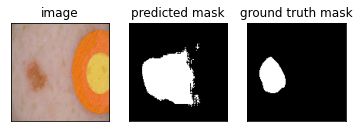

Epoch 62/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0469 - mean_iou: 0.8899 - false_positives: 149.6033 - false_negatives: 148.9890 - val_loss: 0.2907 - val_mean_iou: 0.8125 - val_false_positives: 209.0133 - val_false_negatives: 637.7273

Epoch 00062: val_mean_iou improved from 0.80946 to 0.81251, saving model to checkpoints/train_aug4/100


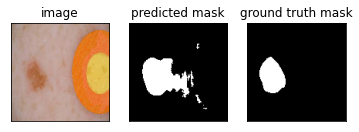

Epoch 63/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0361 - mean_iou: 0.9114 - false_positives: 116.0142 - false_negatives: 123.9380 - val_loss: 0.3775 - val_mean_iou: 0.7868 - val_false_positives: 216.6174 - val_false_negatives: 742.3466

Epoch 00063: val_mean_iou did not improve from 0.81251


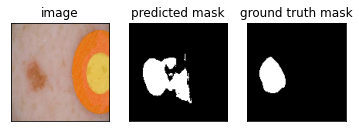

Epoch 64/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0308 - mean_iou: 0.9205 - false_positives: 102.3836 - false_negatives: 98.3059 - val_loss: 0.4192 - val_mean_iou: 0.8041 - val_false_positives: 157.1420 - val_false_negatives: 729.0493

Epoch 00064: val_mean_iou did not improve from 0.81251


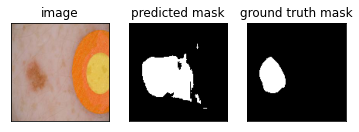

Epoch 65/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0313 - mean_iou: 0.9190 - false_positives: 95.6821 - false_negatives: 110.8896 - val_loss: 0.4297 - val_mean_iou: 0.7704 - val_false_positives: 139.9015 - val_false_negatives: 899.6458

Epoch 00065: val_mean_iou did not improve from 0.81251


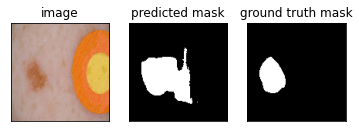

Epoch 66/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0286 - mean_iou: 0.9197 - false_positives: 86.9315 - false_negatives: 100.2711 - val_loss: 0.4130 - val_mean_iou: 0.8026 - val_false_positives: 154.6098 - val_false_negatives: 747.7879

Epoch 00066: val_mean_iou did not improve from 0.81251


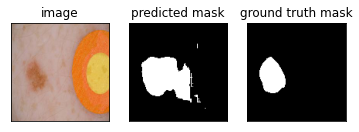

Epoch 67/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0268 - mean_iou: 0.9260 - false_positives: 85.8204 - false_negatives: 92.4100 - val_loss: 0.3567 - val_mean_iou: 0.8025 - val_false_positives: 211.2633 - val_false_negatives: 681.0966

Epoch 00067: val_mean_iou did not improve from 0.81251


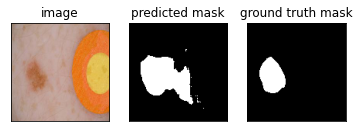

Epoch 68/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0247 - mean_iou: 0.9292 - false_positives: 81.1237 - false_negatives: 84.4743 - val_loss: 0.3855 - val_mean_iou: 0.7972 - val_false_positives: 177.8977 - val_false_negatives: 727.9507

Epoch 00068: val_mean_iou did not improve from 0.81251


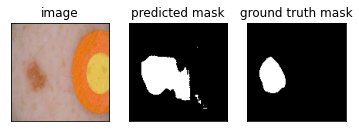

Epoch 69/100
193/193 [==============================] - 52s 268ms/step - loss: 0.0311 - mean_iou: 0.9245 - false_positives: 105.3374 - false_negatives: 101.7910 - val_loss: 0.2974 - val_mean_iou: 0.8094 - val_false_positives: 326.8807 - val_false_negatives: 523.4489

Epoch 00069: val_mean_iou did not improve from 0.81251


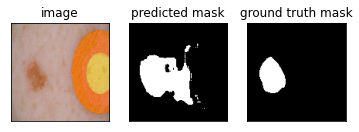

Epoch 70/100
193/193 [==============================] - 52s 268ms/step - loss: 0.0284 - mean_iou: 0.9207 - false_positives: 94.7390 - false_negatives: 88.5522 - val_loss: 0.3858 - val_mean_iou: 0.7910 - val_false_positives: 143.7879 - val_false_negatives: 792.2121

Epoch 00070: val_mean_iou did not improve from 0.81251


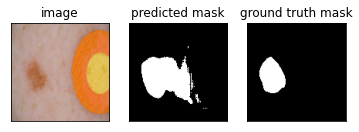

Epoch 71/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0462 - mean_iou: 0.8957 - false_positives: 153.6499 - false_negatives: 135.1430 - val_loss: 0.2950 - val_mean_iou: 0.7968 - val_false_positives: 318.5171 - val_false_negatives: 590.7708

Epoch 00071: val_mean_iou did not improve from 0.81251


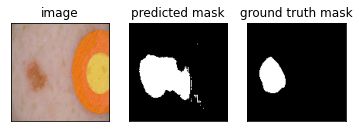

Epoch 72/100
193/193 [==============================] - 51s 265ms/step - loss: 0.0344 - mean_iou: 0.9022 - false_positives: 104.5414 - false_negatives: 112.6136 - val_loss: 0.3583 - val_mean_iou: 0.8080 - val_false_positives: 184.9318 - val_false_negatives: 684.3201

Epoch 00072: val_mean_iou did not improve from 0.81251


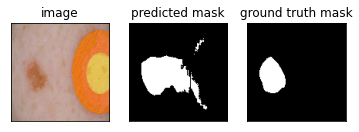

Epoch 73/100
193/193 [==============================] - 51s 265ms/step - loss: 0.0449 - mean_iou: 0.9110 - false_positives: 141.0229 - false_negatives: 148.2038 - val_loss: 0.2523 - val_mean_iou: 0.8080 - val_false_positives: 430.0095 - val_false_negatives: 443.2690

Epoch 00073: val_mean_iou did not improve from 0.81251


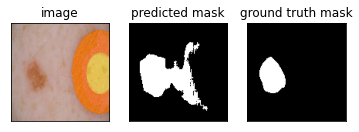

Epoch 74/100
193/193 [==============================] - 51s 265ms/step - loss: 0.0285 - mean_iou: 0.9115 - false_positives: 99.6265 - false_negatives: 88.2394 - val_loss: 0.4297 - val_mean_iou: 0.7914 - val_false_positives: 188.1004 - val_false_negatives: 751.2330

Epoch 00074: val_mean_iou did not improve from 0.81251


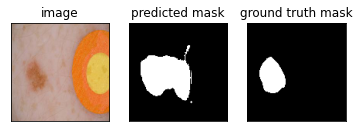

Epoch 75/100
193/193 [==============================] - 51s 265ms/step - loss: 0.0334 - mean_iou: 0.9318 - false_positives: 107.3468 - false_negatives: 112.0512 - val_loss: 0.2347 - val_mean_iou: 0.8000 - val_false_positives: 510.8636 - val_false_negatives: 399.6382

Epoch 00075: val_mean_iou did not improve from 0.81251


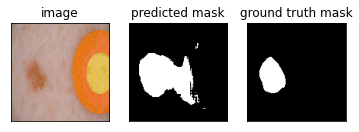

Epoch 76/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0322 - mean_iou: 0.9106 - false_positives: 109.8888 - false_negatives: 97.9672 - val_loss: 0.3905 - val_mean_iou: 0.7953 - val_false_positives: 178.6913 - val_false_negatives: 744.7538

Epoch 00076: val_mean_iou did not improve from 0.81251


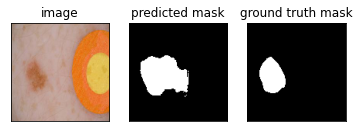

Epoch 77/100
193/193 [==============================] - 52s 267ms/step - loss: 0.0336 - mean_iou: 0.9317 - false_positives: 115.7251 - false_negatives: 107.2066 - val_loss: 0.2734 - val_mean_iou: 0.8083 - val_false_positives: 479.8352 - val_false_negatives: 401.6269

Epoch 00077: val_mean_iou did not improve from 0.81251


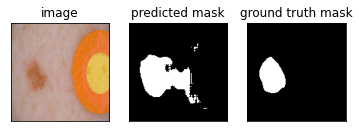

Epoch 78/100
193/193 [==============================] - 52s 269ms/step - loss: 0.0239 - mean_iou: 0.9317 - false_positives: 85.9446 - false_negatives: 72.4297 - val_loss: 0.3806 - val_mean_iou: 0.8120 - val_false_positives: 203.9223 - val_false_negatives: 656.3580

Epoch 00078: val_mean_iou did not improve from 0.81251


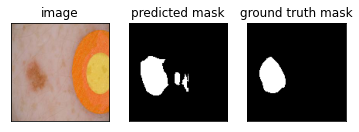

Epoch 79/100
193/193 [==============================] - 52s 268ms/step - loss: 0.0285 - mean_iou: 0.9434 - false_positives: 101.4161 - false_negatives: 89.0966 - val_loss: 0.2741 - val_mean_iou: 0.8154 - val_false_positives: 411.7083 - val_false_negatives: 433.8257

Epoch 00079: val_mean_iou improved from 0.81251 to 0.81539, saving model to checkpoints/train_aug4/100


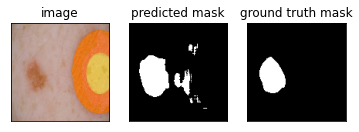

Epoch 80/100
193/193 [==============================] - 51s 266ms/step - loss: 0.0241 - mean_iou: 0.9364 - false_positives: 82.7239 - false_negatives: 80.3251 - val_loss: 0.4141 - val_mean_iou: 0.7990 - val_false_positives: 219.4830 - val_false_negatives: 678.3352

Epoch 00080: val_mean_iou did not improve from 0.81539


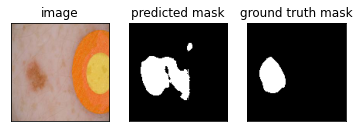

Epoch 81/100
193/193 [==============================] - 51s 265ms/step - loss: 0.0282 - mean_iou: 0.9416 - false_positives: 90.8891 - false_negatives: 97.7205 - val_loss: 0.3251 - val_mean_iou: 0.7952 - val_false_positives: 531.3087 - val_false_negatives: 399.7784

Epoch 00081: val_mean_iou did not improve from 0.81539


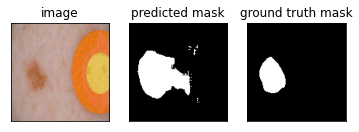

Epoch 82/100
193/193 [==============================] - 52s 270ms/step - loss: 0.0273 - mean_iou: 0.9327 - false_positives: 88.5847 - false_negatives: 90.6005 - val_loss: 0.3638 - val_mean_iou: 0.7826 - val_false_positives: 309.5493 - val_false_negatives: 674.4034

Epoch 00082: val_mean_iou did not improve from 0.81539


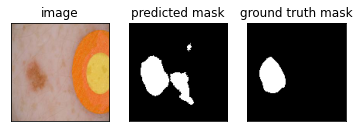

Epoch 83/100
193/193 [==============================] - 52s 269ms/step - loss: 0.0474 - mean_iou: 0.9065 - false_positives: 140.5503 - false_negatives: 141.7974 - val_loss: 0.2583 - val_mean_iou: 0.8118 - val_false_positives: 385.3864 - val_false_negatives: 487.2405

Epoch 00083: val_mean_iou did not improve from 0.81539


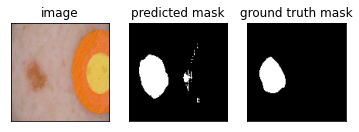

Epoch 84/100
193/193 [==============================] - 51s 266ms/step - loss: 0.0368 - mean_iou: 0.9158 - false_positives: 125.9318 - false_negatives: 112.3736 - val_loss: 0.4242 - val_mean_iou: 0.7958 - val_false_positives: 150.6383 - val_false_negatives: 783.0246

Epoch 00084: val_mean_iou did not improve from 0.81539


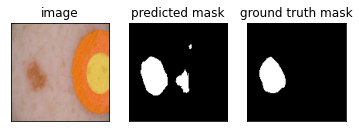

Epoch 85/100
193/193 [==============================] - 51s 265ms/step - loss: 0.0280 - mean_iou: 0.9404 - false_positives: 92.6387 - false_negatives: 91.9085 - val_loss: 0.3407 - val_mean_iou: 0.8217 - val_false_positives: 199.9299 - val_false_negatives: 611.0720

Epoch 00085: val_mean_iou improved from 0.81539 to 0.82167, saving model to checkpoints/train_aug4/100


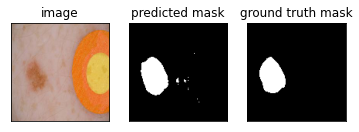

Epoch 86/100
193/193 [==============================] - 52s 268ms/step - loss: 0.0255 - mean_iou: 0.9414 - false_positives: 89.6277 - false_negatives: 80.6149 - val_loss: 0.3722 - val_mean_iou: 0.7957 - val_false_positives: 191.6383 - val_false_negatives: 718.3182

Epoch 00086: val_mean_iou did not improve from 0.82167


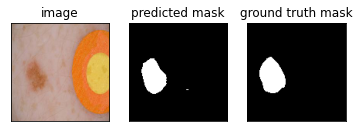

Epoch 87/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0285 - mean_iou: 0.9357 - false_positives: 90.0133 - false_negatives: 94.8355 - val_loss: 0.3620 - val_mean_iou: 0.8111 - val_false_positives: 198.5492 - val_false_negatives: 668.5132

Epoch 00087: val_mean_iou did not improve from 0.82167


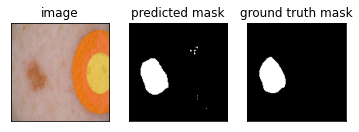

Epoch 88/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0407 - mean_iou: 0.9256 - false_positives: 132.3670 - false_negatives: 118.3086 - val_loss: 0.3616 - val_mean_iou: 0.7878 - val_false_positives: 218.8674 - val_false_negatives: 758.1155

Epoch 00088: val_mean_iou did not improve from 0.82167


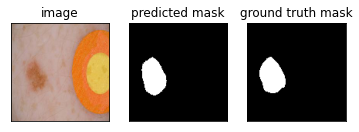

Epoch 89/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0490 - mean_iou: 0.9000 - false_positives: 163.4530 - false_negatives: 138.3779 - val_loss: 0.2707 - val_mean_iou: 0.8117 - val_false_positives: 244.1723 - val_false_negatives: 604.4053

Epoch 00089: val_mean_iou did not improve from 0.82167


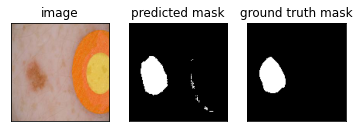

Epoch 90/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0322 - mean_iou: 0.9344 - false_positives: 102.3796 - false_negatives: 110.5048 - val_loss: 0.3782 - val_mean_iou: 0.7993 - val_false_positives: 193.9792 - val_false_negatives: 722.4053

Epoch 00090: val_mean_iou did not improve from 0.82167


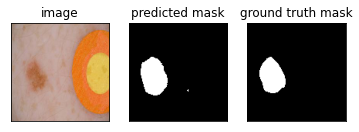

Epoch 91/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0258 - mean_iou: 0.9398 - false_positives: 85.7866 - false_negatives: 81.7824 - val_loss: 0.4006 - val_mean_iou: 0.8160 - val_false_positives: 175.2481 - val_false_negatives: 665.1458

Epoch 00091: val_mean_iou did not improve from 0.82167


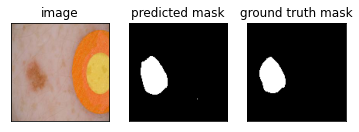

Epoch 92/100
193/193 [==============================] - 51s 263ms/step - loss: 0.0256 - mean_iou: 0.9447 - false_positives: 86.4226 - false_negatives: 83.0990 - val_loss: 0.3964 - val_mean_iou: 0.8016 - val_false_positives: 229.2367 - val_false_negatives: 673.2462

Epoch 00092: val_mean_iou did not improve from 0.82167


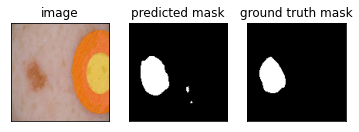

Epoch 93/100
193/193 [==============================] - 52s 270ms/step - loss: 0.0231 - mean_iou: 0.9432 - false_positives: 79.0792 - false_negatives: 71.7809 - val_loss: 0.4158 - val_mean_iou: 0.8139 - val_false_positives: 159.0909 - val_false_negatives: 691.9337

Epoch 00093: val_mean_iou did not improve from 0.82167


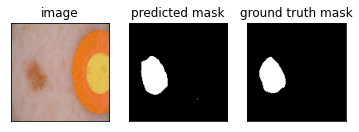

Epoch 94/100
193/193 [==============================] - 52s 272ms/step - loss: 0.0228 - mean_iou: 0.9463 - false_positives: 74.5514 - false_negatives: 75.6721 - val_loss: 0.3441 - val_mean_iou: 0.8129 - val_false_positives: 307.8618 - val_false_negatives: 540.7424

Epoch 00094: val_mean_iou did not improve from 0.82167


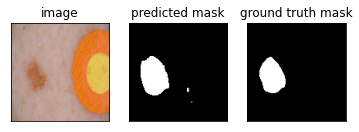

Epoch 95/100
193/193 [==============================] - 51s 266ms/step - loss: 0.0207 - mean_iou: 0.9466 - false_positives: 70.2501 - false_negatives: 65.5122 - val_loss: 0.4085 - val_mean_iou: 0.7990 - val_false_positives: 179.3542 - val_false_negatives: 722.2727

Epoch 00095: val_mean_iou did not improve from 0.82167


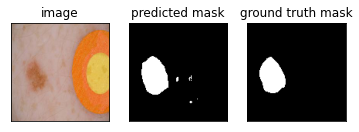

Epoch 96/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0233 - mean_iou: 0.9420 - false_positives: 76.3313 - false_negatives: 75.9062 - val_loss: 0.3381 - val_mean_iou: 0.7984 - val_false_positives: 309.2102 - val_false_negatives: 585.4943

Epoch 00096: val_mean_iou did not improve from 0.82167


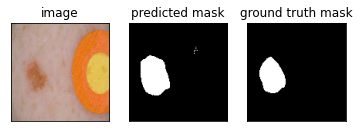

Epoch 97/100
193/193 [==============================] - 51s 264ms/step - loss: 0.0242 - mean_iou: 0.9357 - false_positives: 80.5376 - false_negatives: 75.0856 - val_loss: 0.4688 - val_mean_iou: 0.8041 - val_false_positives: 136.5019 - val_false_negatives: 757.8428

Epoch 00097: val_mean_iou did not improve from 0.82167


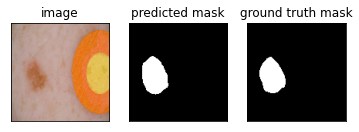

Epoch 98/100
193/193 [==============================] - 51s 266ms/step - loss: 0.0216 - mean_iou: 0.9401 - false_positives: 70.8808 - false_negatives: 71.0905 - val_loss: 0.4017 - val_mean_iou: 0.7883 - val_false_positives: 242.9356 - val_false_negatives: 748.9583

Epoch 00098: val_mean_iou did not improve from 0.82167


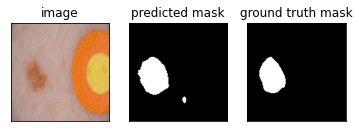

Epoch 99/100
193/193 [==============================] - 51s 267ms/step - loss: 0.0223 - mean_iou: 0.9364 - false_positives: 76.8664 - false_negatives: 69.0368 - val_loss: 0.4202 - val_mean_iou: 0.8128 - val_false_positives: 171.8636 - val_false_negatives: 675.2216

Epoch 00099: val_mean_iou did not improve from 0.82167


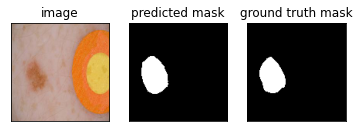

Epoch 100/100
193/193 [==============================] - 52s 267ms/step - loss: 0.0226 - mean_iou: 0.9408 - false_positives: 78.0235 - false_negatives: 70.5564 - val_loss: 0.3199 - val_mean_iou: 0.8156 - val_false_positives: 347.5720 - val_false_negatives: 481.5435

Epoch 00100: val_mean_iou did not improve from 0.82167


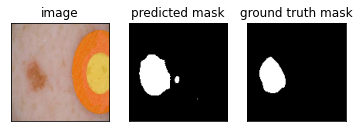

In [27]:
model.fit(train_data,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=validation_data,
          shuffle=True,
          steps_per_epoch=ceil(TRAIN_COUNT/BATCH_SIZE),
          validation_steps=ceil(VALIDATION_COUNT/BATCH_SIZE),
          callbacks=[best_checkpoint, image_callback, board_callback],
          initial_epoch=29
          )

In [28]:
%load_ext tensorboard
%tensorboard --logdir logs/train_aug4

## Evaluate pix2pix4 augmented model on test images<a name='evaluate_augment_pix2pix_no_jittering'></a>

In [30]:
TEST_DIR = '../../test_dataset/'

flow_args = {k: v for k, v in flow_args.items()}
flow_args['shuffle'] = False

test_generator = zip(
    image_generator.flow_from_directory(
        directory=TEST_DIR,
        classes=['image'],
        color_mode='rgb',
        **flow_args
    ),
    mask_generator.flow_from_directory(
        directory=TEST_DIR,
        classes=['mask'],
        color_mode='grayscale',
        **flow_args
    )
)

test_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, test_generator),
    **dataset_args
)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [31]:
TEST_COUNT = 100

model = get_model(
    optimizer=tf.keras.optimizers.Adam,
    learning_rate=1e-3,
    dropout_rate=0.4
)

model.load_weights(f'checkpoints/train_aug4/100')

evaluate = model.evaluate(
    test_data,
    steps=ceil(TEST_COUNT/BATCH_SIZE),
    return_dict=True
)

iou = evaluate['mean_iou']
fp = evaluate['false_positives']
fn = evaluate['false_negatives']

print()
print(f'Test mean IoU: {iou:.2f}')
print(f'Test mean false positives: {fp:.2f}')
print(f'Test mean false negatives: {fn:.2f}')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_39 (Sequential)      (None, 64, 64, 64)   3072        input_4[0][0]                    
__________________________________________________________________________________________________
sequential_40 (Sequential)      (None, 32, 32, 128)  131072      sequential_39[0][0]              
__________________________________________________________________________________________________
sequential_41 (Sequential)      (None, 16, 16, 256)  525312      sequential_40[0][0]              
____________________________________________________________________________________________

Intersection over union value dropped in comparison with U-net trained only on real data. This type of augmentation is not suitable.